# 0.0. IMPORTS

In [1]:
# import the relevant libraries
import math
import inflection
import numpy as np
import pandas as pd
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb
import pickle
import random
import warnings
warnings.filterwarnings( 'ignore' )

import seaborn as sns
sns.set()

from tabulate        import tabulate
from scipy           import stats
from boruta          import BorutaPy
from datetime        import datetime
from datetime        import timedelta
from IPython.display import Image

from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error

## 0.1. Helper Functions

In [2]:
# chi2 formula - Applied on 4.3.2. Categorical Attributes
def cramer_v( x, y ):
    # calculate confusion matrix (cm), contingency table
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    # calculate chi2
    chi2 = stats.chi2_contingency( cm )[0]
    # chi2 correction
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    # k correction
    kcorr = k - (k-1)**2/(n-1)
    # r correction
    rcorr = r - (r-1)**2/(n-1)
    
    # return Cramer V
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [3]:
# mean absolute percentage error formula - applied on ml_error function below
def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y - yhat ) / y) )

# Mean Percentage Error - applied on 8.0. STEP 08 - HYPERPARAMETER FINE TUNING
def mean_percentage_error(y, yhat):
    return np.mean( ( y - yhat ) / y)

# Error summary function - applied on 7.0. STEP 07 - MACHINE LEARNING MODELLING
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE' : rmse}, index=[0])

# Cross-validation function - applied on 7.0. STEP 07 - MACHINE LEARNING MODELLING
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    # errors lists to concatenate the values
    mae_list = []
    mape_list = []
    rmse_list = []

    # Cross-validation k-fold
    # k-fold range. reversed: range from max to min.
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation
        # subtract 6 weeks (6*7) from date max: first date of validation
        validation_start_date = x_training['date'].max() - timedelta( days=k*6*7 )
        validation_end_date = x_training['date'].max() - timedelta( days=(k-1)*6*7 )

        # filtering dataset for training and validation
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
    
        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
        # mean and standard deviation of errors after cross-validation
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV': np.round( np.mean( mae_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list), 2 ).astype( str ),
                           'MAPE CV': np.round( np.mean( mape_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list), 2 ).astype( str ),
                           'RMSE CV': np.round( np.mean( rmse_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list), 2 ).astype( str ) }, index=[0] )
    

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('C:/Users/santo/repos/DataScience-Em-Producao/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:/Users/santo/repos/DataScience-Em-Producao/data/store.csv', low_memory=False)

# merge
# both files share the same 'Store' column, therefore on='Store'
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# Note on pd.read_csv low_memory (from pandas website):
# Internally process the file in chunks, resulting in lower memory use while parsing, but possibly mixed type inference. 
# To ensure no mixed types either set False, or specify the type with the dtype parameter. 
# Note that the entire file is read into a single DataFrame regardless, use the chunksize or iterator parameter to return 
# the data in chunks. (Only valid with C parser).

In [6]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
484322,83,3,2014-04-23,3134,309,1,0,0,1,a,a,2710.0,NaN,NaN,0,NaN,NaN,NaN
6750,61,6,2015-07-25,4675,576,1,0,0,0,a,c,350.0,12.0,2007.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
118824,635,4,2015-04-16,7050,681,1,1,0,0,a,a,27530.0,4.0,2014.0,0,NaN,NaN,NaN
123500,851,7,2015-04-12,0,0,0,0,0,0,d,c,2330.0,NaN,NaN,1,49.0,2014.0,"Mar,Jun,Sept,Dec"
973534,925,6,2013-02-09,6029,1175,1,0,0,0,c,a,470.0,3.0,2007.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0. STEP 01 - DATA DESCRIPTION

In [5]:
# copy original data
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [20]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [22]:
df1['date'].describe()

count                 1017209
unique                    942
top       2015-06-09 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: date, dtype: object

In [23]:
df1[['competition_open_since_year', 'promo2_since_year']].describe()

,competition_open_since_year,promo2_since_year
count,693861.000000,509178.000000
mean,2008.690228,2011.752774
std,5.992644,1.662870
min,1900.000000,2009.000000
25%,2006.000000,2011.000000
50%,2010.000000,2012.000000
75%,2013.000000,2013.000000
max,2015.000000,2015.000000


In [24]:
df1['store'].value_counts()

1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: store, Length: 1115, dtype: int64

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [26]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
96663,774,3,2015-05-06,6218,767,1,1,0,0,a,c,640.0,9.0,2013.0,0,NaN,NaN,NaN


In [27]:
df1['competition_distance'].max()

75860.0

In [9]:
#competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
# Same assumption as promo2_since_week
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
dtype: int64

## 1.6. Change Types

In [11]:
# Some operations may have changed the data types
# Check the data types again and change them (if necessary)
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [12]:
# change competition_open_since_month type to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

# change competition_open_since_year type to int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# change promo2_since_week type to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

# change promo2_since_year type to int
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [13]:
# Check data type
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

## 1.7. Descriptive Statistics

Descriptive Statistics is important for two main reasons:
1. Obtain business know-how;
2. Detect some errors.

Within the Descriptive Statistics there are two main metrics:
1. Dispersion metrics (standard deviation, min, max, skew, kurtosis);
2. Central Tendency metrics (for example mean and median)

In [33]:
# Select numerical variables
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# Select categorical variables
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [34]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - standard deviation (std), min, max, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T

# Dispersion - values' Range
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T

# Dispersion - skew and kurtosis
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate all data frames
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# display dataframe
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


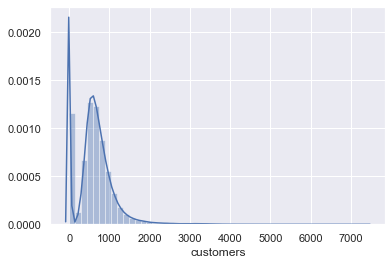

In [35]:
sns.distplot( df1['customers'])

### 1.7.2. Categorical Attributes

In [36]:
# Check unique entries of categorical attributes
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

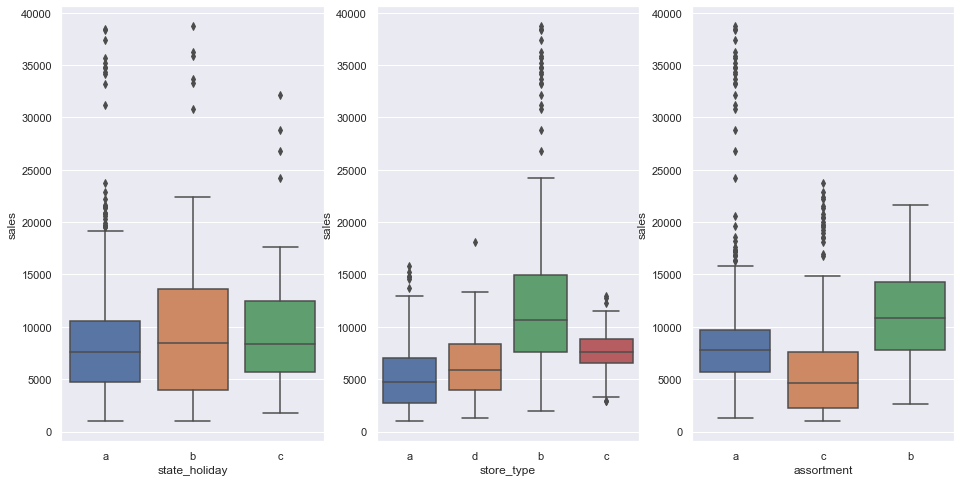

In [37]:
# Filter only holiday (regular day == 0) and sales higher than 0 (stores open)
# The filter is needed to better off boxplot visualization.
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,8))

# boxplot state_holiday (without regular days) with respect to sales
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

# boxplot store_type
plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

# boxplot assortment
plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0. STEP 02 - FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

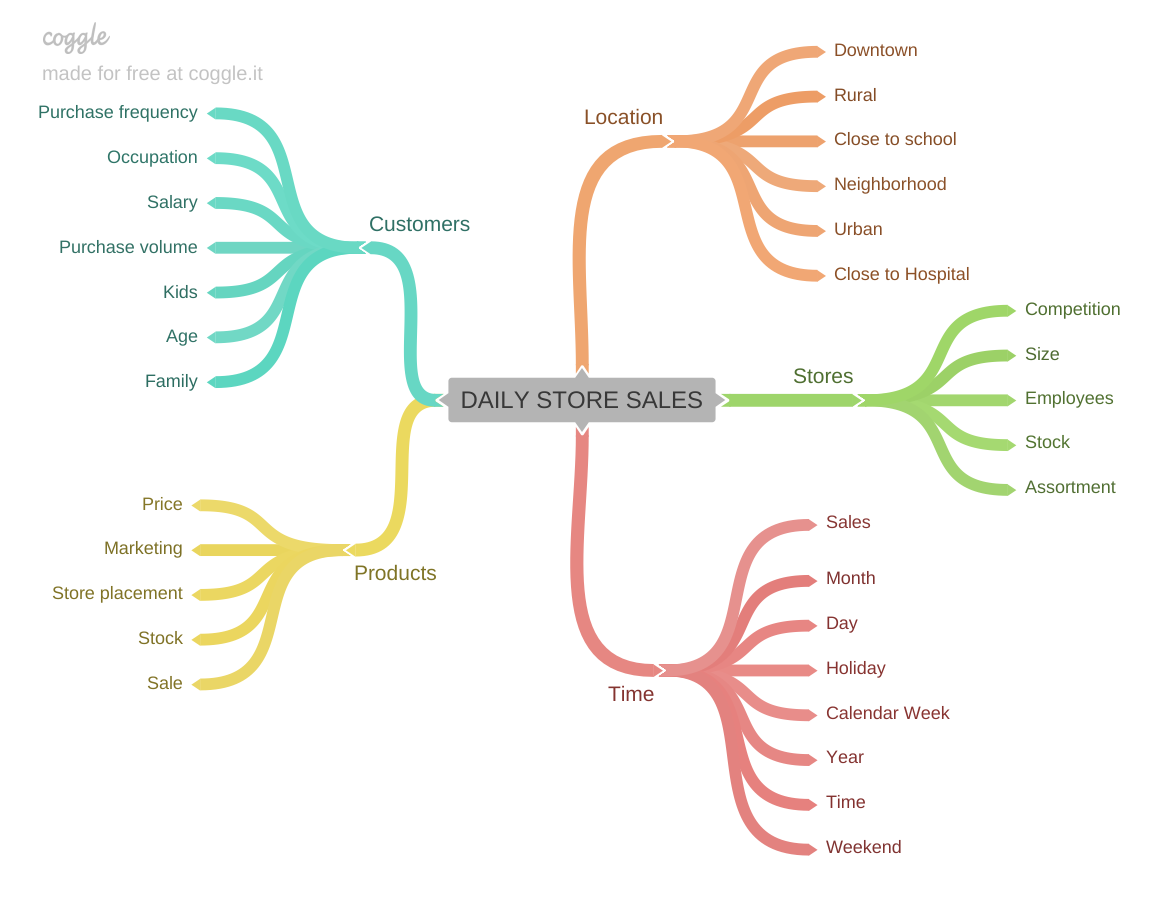

In [40]:
Image('C:/Users/santo/repos/DataScience-Em-Producao/img/Mindmaphypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis

**1.** Stores with bigger staff (employees) should sell more.

**2.** Stores with bigger Stock should sell more.

**3.** Stores with bigger size should sell more.

**4.** Stores with bigger Assortment should sell more.

**5.** Stores with competition closer should sell less.

**6.** Stores with longer time competition should sell more.

### 2.2.2. Product Hypothesis

**1.** Stores that invest more on Marketing should sell more.

**2.** Stores that expose more the products (Store Placement) should sell more.

**3.** Stores with lower product prices should sell more.

**4.** Stores with more agressive Sale (bigger discount) should sell more.

**5.** Stores with longer Sale (promo) should sell more.

**6.** Stores with more Sale (promo) days should sell more.

**7.** Stores with more consecutive Sale (promo) should sell more.

### 2.2.3. Time Hypothesis

**1.** Stores open on Christmas time should sell more.

**2.** Stores should sell more throughout the years.

**3.** Stores should sell more on second semester.

**4.** Stores should sell more after the 10th months day.

**5.** Stores should sell less on weekend.

**6.** Stores should sell less while school vacation.

### 2.2.4. Customers Hypothesis

**1.** Stores with more customers should sell more.

## 2.3. Final Hypothesis List (Based on the data available in the original dataset)

**1.** Stores with bigger Assortment should sell more.

**2.** Stores with competition closer should sell less.

**3.** Stores with longer time competition should sell more.

**4.** Stores with longer Sale (promo) should sell more.

**5.** Stores with more Sale (promo) days should sell more.

**6.** Stores with more consecutive Sale (promo) should sell more.

**7.** Stores open on Christmas time should sell more.

**8.** Stores should sell more throughout the years.

**9.** Stores should sell more on second semester.

**10.** Stores should sell more after the 10th months day.

**11.** Stores should sell less on weekend.

**12.** Stores should sell less while school vacation.

**13.** Stores with more customers should sell more.

## 2.4. Feature Engineering

In [15]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
# Bring together competition_open_since_month and competition_open_since_year
# Assumption: day = 1 in order to consider the full month.
df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# 1. Create a string 'year-week'
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
# 3. create promo_time_week column with the difference between date and promo_since in weeks.
# df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [42]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - VARIABLES FILTERING

In [16]:
df3 = df2.copy()

In [44]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo_interval,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,"Jan,Apr,Jul,Oct",2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Line Filtering

In [17]:
# closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
# sales = 0 will also be removed.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [18]:
# Remove outliers - 0,1% from highest sales values
q = df3['sales'].quantile(0.999)
df3 = df3[df3['sales'] < q]

## 3.2. Columns Selection

In [19]:
# open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
# promo_interval generated new columns in the feature engineering step and is no longer needed.
# month_map is an auxiliary column and hence will be removed.
cols_drop = ['open', 'promo_interval']
df3 = df3.drop( cols_drop, axis=1 )

In [23]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'year', 'month', 'day', 'week_of_year',
       'year_week', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

In [21]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic


# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [20]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

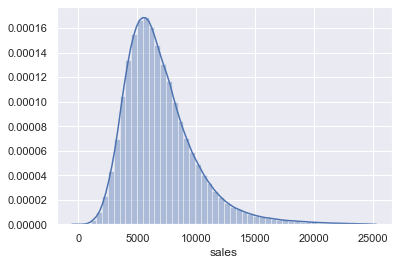

In [50]:
sns.distplot( df4['sales'] )

In [51]:
df4['sales'].describe()

count    843493.000000
mean       6935.160317
std        3033.777794
min          46.000000
25%        4858.000000
50%        6366.000000
75%        8352.000000
max       24664.000000
Name: sales, dtype: float64

### 4.1.2. Numerical Variable

In [52]:
# select numerical columns
numeric_cols = [cname for cname in df4.columns if df4[cname].dtype in ['int64', 'float64']]
num_attributes = df4[numeric_cols]

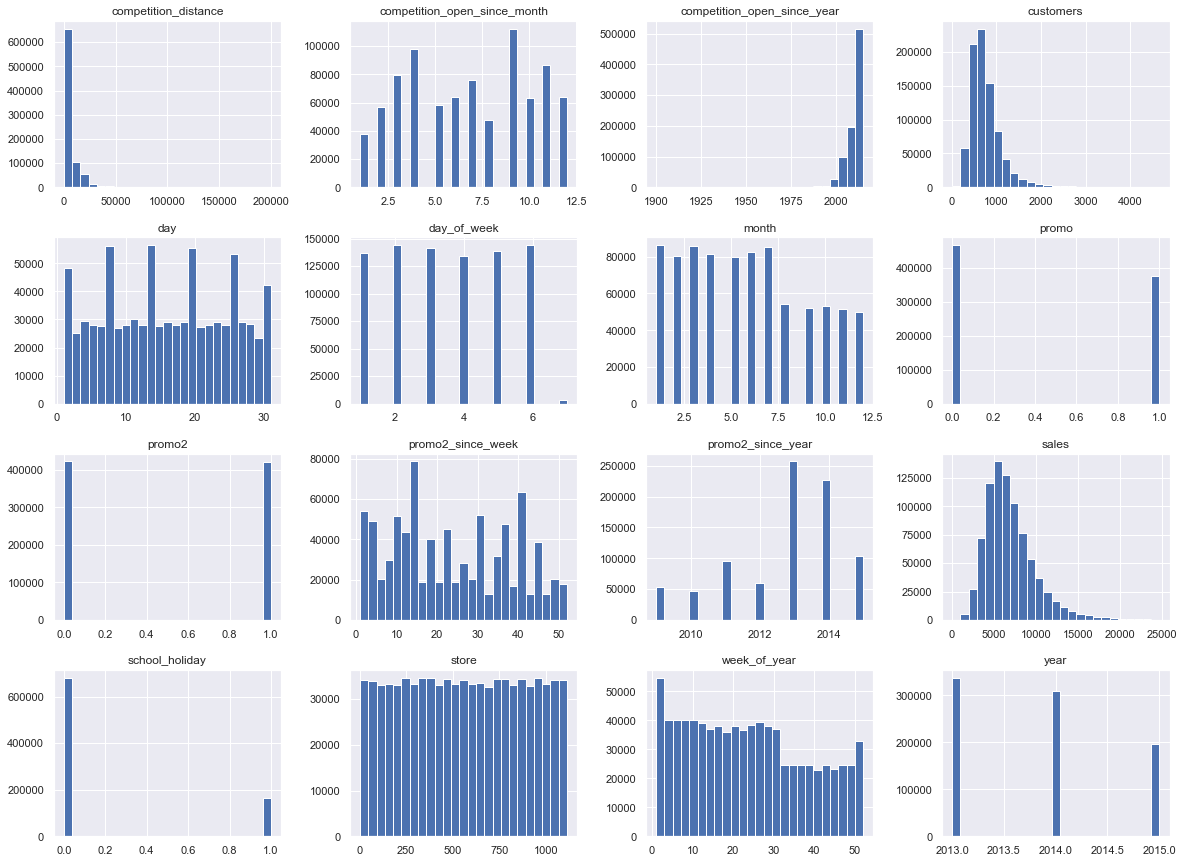

In [53]:
# generate histogram for all numerical variables
num_attributes.hist( bins=25, figsize=(20,15) );

### 4.1.3. Categorical Variable

In [54]:
# select categorial columns
categorical_cols = [cname for cname in df4.columns if df4[cname].dtype == "object"]
cat_attributes = df4[categorical_cols]

In [55]:
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


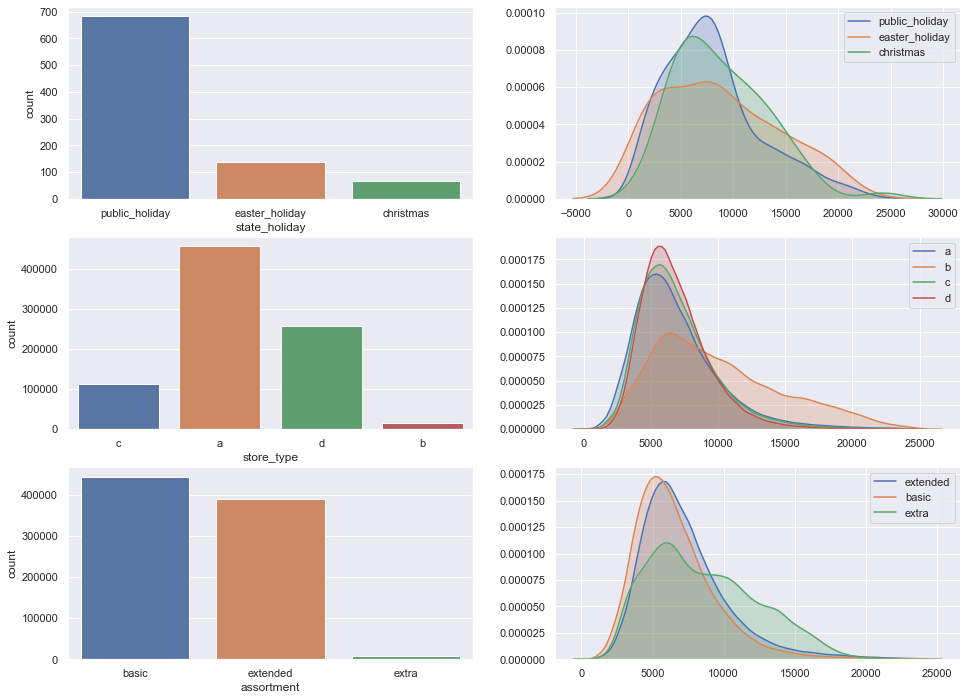

In [56]:
# Set up the matplotlib figure
f, axes = plt.subplots(3, 2, figsize=(16, 12))

# state_holiday
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2. Bivariate Analysis

### H1. Stores with bigger Assortment should sell more.
**FALSE** Stores with BIGGER ASSORTMENT sell LESS.

Comentários:
O resultado da análise é um insight pois as lojas com maior sortimento vendem menos, ou seja, é contraintuitivo.

A variável assortment explica dois tipos de comportamento, portanto pode ser relevante para o modelo. Relevância baixa.

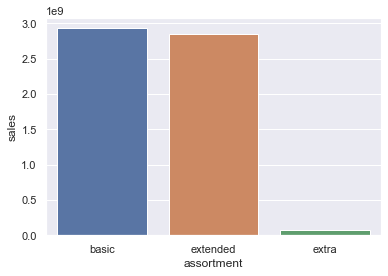

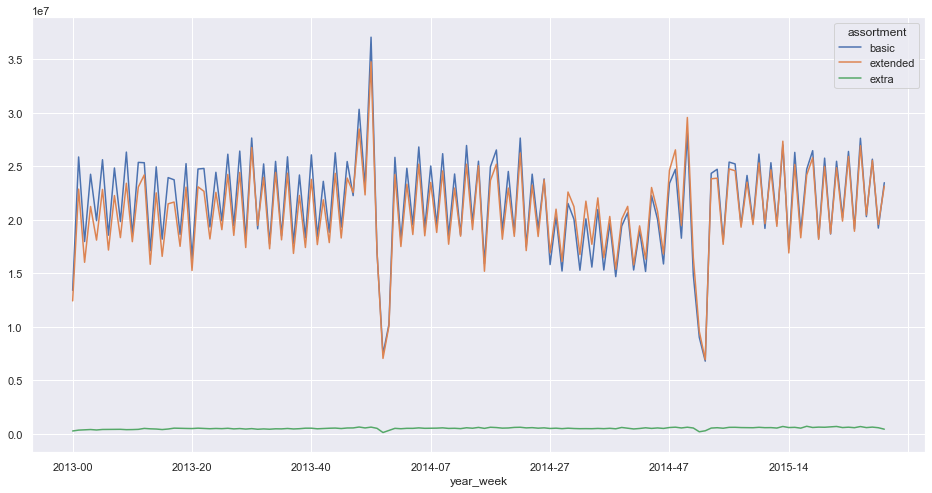

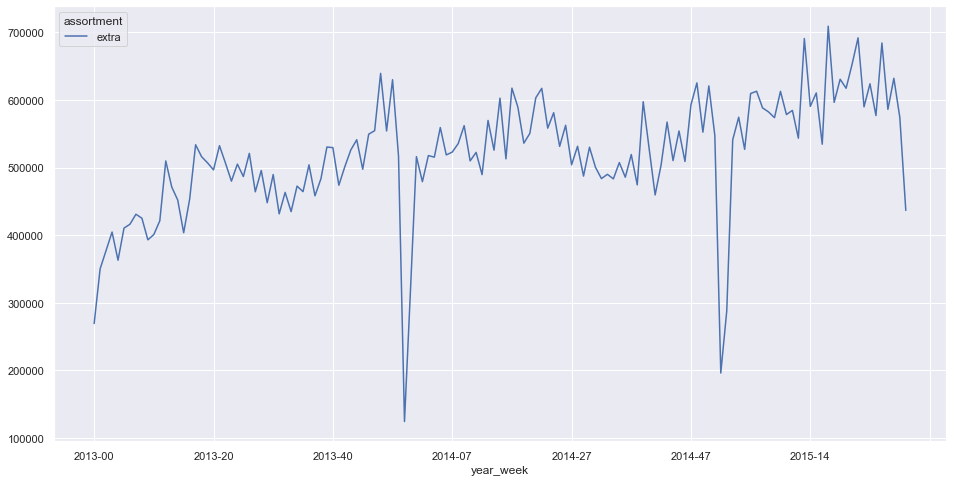

In [57]:
# plot the sum of sales by assortment.
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

# sum of all sales by assortment and by year_week.
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()

# pivot for year_week as line (index), assortment types as columns and sales as values.
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')
aux3.head()
aux3.plot(figsize=(16,8))

# plot the assortment type 'extra' in order to check its behaviour.
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(16,8))

# Assumption based on the available data description: big assortment = 'extra'.
# After the graphs analysis we can conclude that big assortment (extra) does not sell more than the other ones.
# Therefore we can claim that the Hypothesis H1 is not valid (false).

In [58]:
# sum of all sales by assortment and by year_week.
# remember: aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13408905
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,25870719
4,2013-01,extended,22866520


In [59]:
# aux3 contains the pivot made above for year_week as line (index), assortment types as columns and sales as values.
# remember: aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales')
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13408905,12425669,269404
2013-01,25870719,22866520,350279
2013-02,17970974,16029584,377207
2013-03,24255494,21243431,404662
2013-04,19918809,18104936,363061


### H2. Stores with competition closer should sell less.
**FALSE** Stores with COMPETITION CLOSE sell MORE.

Comentários:
O resultado da análise é um insight pois as lojas com a concorrência mais próxima vendem mais, ou seja, é totalmente contra o senso comum.

A correlação do método de pearson varia de -1 a 1, sendo que em 1 as variáveis são perfeitamente correlacionadas positivamente e -1 elas tem uma correlação negativa.
O valor de -0,23 indica uma correlação fraca. Pode ser relevante para o modelo, mas de uma maneira mais fraca. Relevância média.

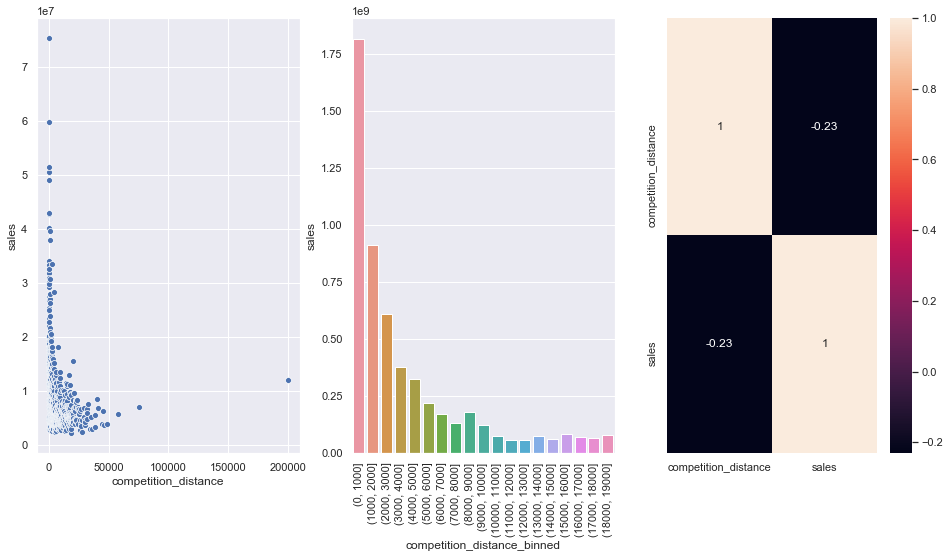

In [60]:
# sum of sales by competition_distance
aux2_1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# set up figure size
f, ax = plt.subplots( 1, 3, figsize=(16,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1 )
# scatter plot competition_distance and sales (aux2_1)
sns.scatterplot( x='competition_distance', y='sales', data=aux2_1)

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2 )
# create bins to group the values for better plot visualization
bins = list( np.arange( 0, 20000, 1000 ) )
# arrange the values to each corresponding group (bins) 
# and store it in the new column 'competition_distance_binned'.
aux2_1['competition_distance_binned'] = pd.cut( aux2_1['competition_distance'], bins=bins )
# sum of sales by competition_distance_binned
aux2_2 = aux2_1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
# plot sum of sales by competition_distance_binned
sns.barplot( x='competition_distance_binned', y='sales', data=aux2_2 );
# axis rotation
plt.xticks( rotation=90 )

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3 )
# correlation weight between competition_distance and sales
sns.heatmap( aux2_1.corr( method='pearson' ), annot=True );

In [61]:
aux2_1.sample(4)

,competition_distance,sales,competition_distance_binned
145,1630.0,4883888,"(1000, 2000]"
58,600.0,6980916,"(0, 1000]"
306,4110.0,5231510,"(4000, 5000]"
221,2630.0,10159175,"(2000, 3000]"


### H3. Stores with longer time competition should sell more.
**FALSE** Stores with LONGER TIME COMPETITION sell LESS.

Comentários:
O resultado da análise é um insight pois lojas com mais tempo de concorrência vendem menos, ou seja, é contraintuitivo.

Correlação entre o tempo que os competidores começaram e as vendas. Relação de pearson de 0,1. Relevância média.

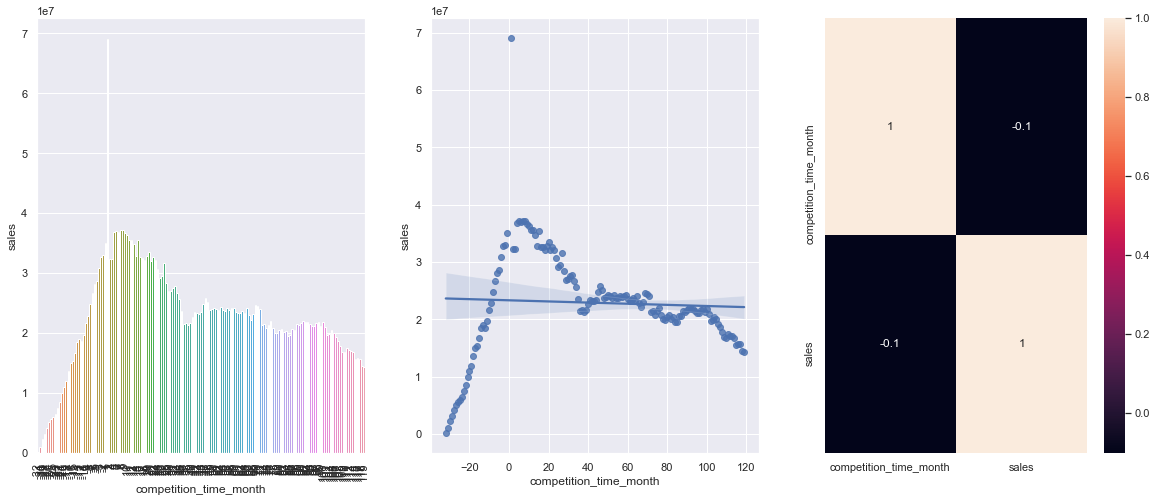

In [62]:
# sum of sales by competition_time_month
aux3_1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month').sum().reset_index()

# Filter values lower than 120 in order to check the first 120 months of competition
# Filter competition time == 0 (competition open in the same month of the sale)
aux3_2 = aux3_1[(aux3_1['competition_time_month'] < 120) & ( aux3_1['competition_time_month'] != 0 )]

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# grid of plots - 1st plot
plt.subplot( 1, 3, 1)
# bar plot
sns.barplot( x='competition_time_month', y='sales', data=aux3_2)
# rotate x axis labels
plt.xticks( rotation=90 );

# grid of plots - 2nd plot
plt.subplot( 1, 3, 2)
# plot regplot
sns.regplot( x='competition_time_month', y='sales', data=aux3_2);

# grid of plots - 3rd plot
plt.subplot( 1, 3, 3)
sns.heatmap( aux3_1.corr(method='pearson'), annot=True)

# competition time month negative values mean that the competition will open a new store soon in the future.
# the bar plot shows that competition time month values near to zero represents more sales than bigger competition time month.

### **H4.** Stores with longer Sale (promo) should sell more.
**FALSE** Stores with longer Sale (promo) sell less after some promo period.

Comentários:
O resultado da análise pode ser um insight pois as lojas com mais tempo de promoção vendem menos, ou seja, é contrário ao que normalmente se acredita.

Relação de pearson: 0,029. Provavelmente será uma variável não relevante para o modelo. Relevância baixa.

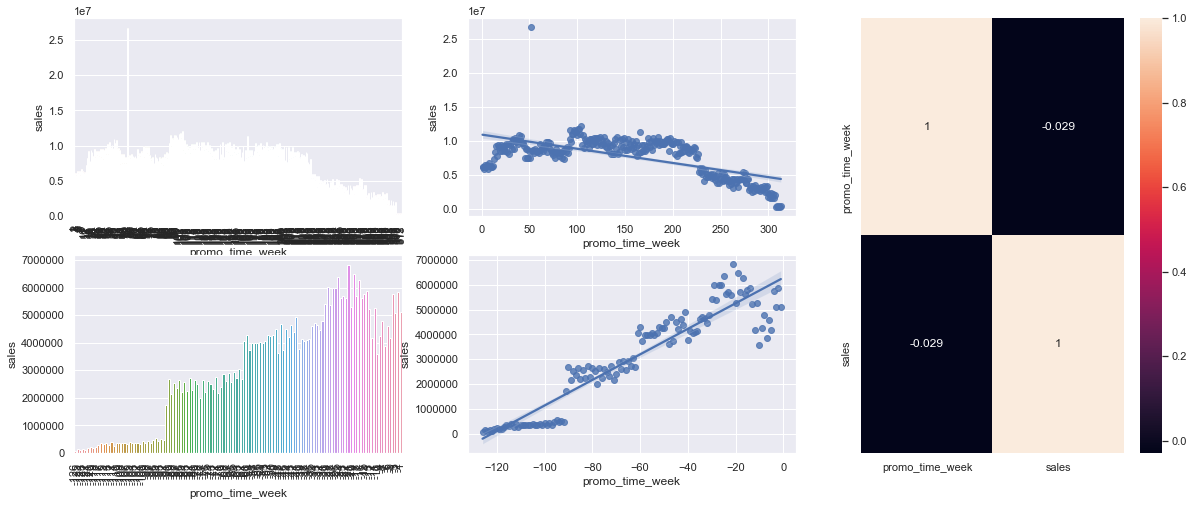

In [63]:
# two periods of promo: the standard (promo) and the extended (promo 2).
# promo_time_week > 0 means the sale at that date was done in the promo 2 period (extended).
# promo_time_week < 0 means the sale at that date was done in the standard promo period.

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# Grid spec - plot
grid = gridspec.GridSpec( 2, 3)

# sum of sales by promo_time_week
aux4_1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# sort the data into extended promo period (promo2).
plt.subplot( grid[0,0] )
aux4_2 = aux4_1[aux4_1['promo_time_week'] > 0] # promo extended (promo 2)
# bar plot
sns.barplot( x='promo_time_week', y='sales', data=aux4_2 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux4_2 );

# sort the data into standard promo period.
plt.subplot( grid[1,0] )
aux4_3 = aux4_1[aux4_1['promo_time_week'] < 0] # promo standard
# bar plot
sns.barplot( x='promo_time_week', y='sales', data=aux4_3 );
# rotate x axis labels
plt.xticks( rotation=90 );

# reg plot to check tendency
plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux4_3 );

# Correlation strength - heatmap
plt.subplot( grid[:,2] )
sns.heatmap( aux4_1.corr( method='pearson'), annot=True );

### **H5.** Stores with more Sale (promo) days should sell more.

**TRUE** Stores with more Sale (promo) days sell more.

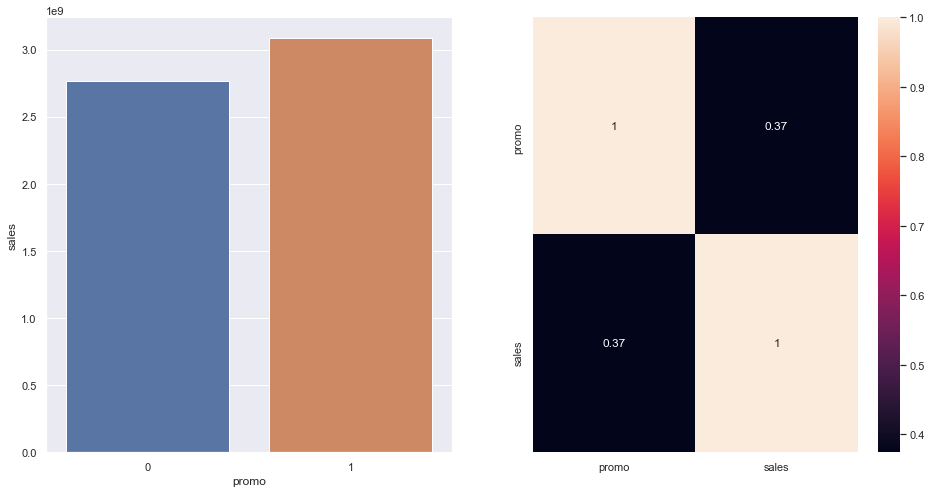

In [96]:
# promo, sales
# set up plot
plt.subplots(1, 2, figsize=(16,8))

# barplot
aux5_1 = df4[['promo', 'sales']].groupby( 'promo' ).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='promo', y='sales', data=aux5_1);

# heatmap
plt.subplot(1,2,2)
aux5_4 = df4[['promo', 'sales']]
sns.heatmap(aux5_4.corr(method='pearson'), annot=True);

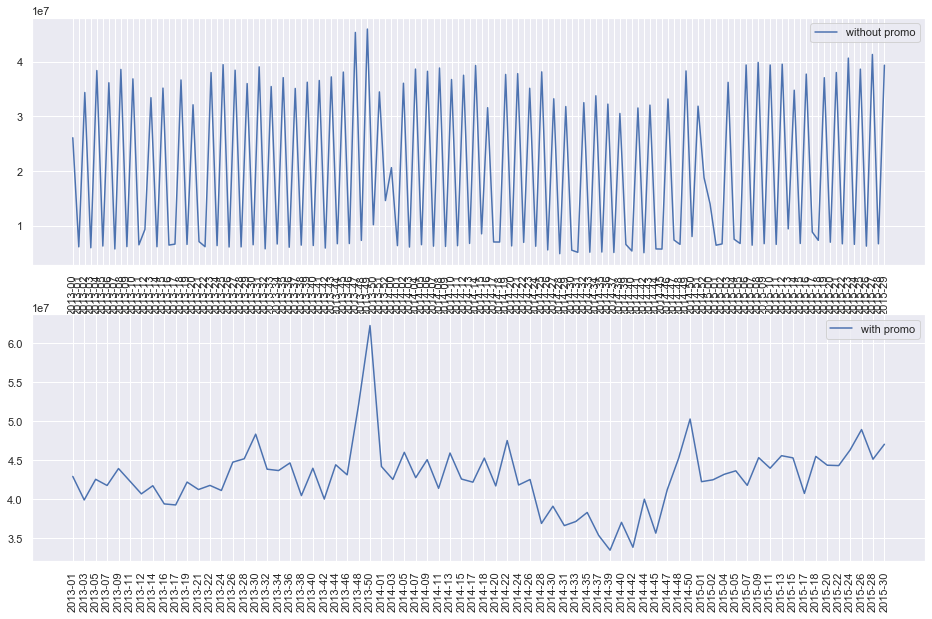

In [65]:
# time series promo, year_week and sales
# without promo
aux5_2 = df4[df4['promo'] == 0][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux5_2 = aux5_2.set_index('year_week')
# set up plot
plt.subplots(2, 1, figsize=(16,10))
# lineplot promo == 0 - 1st plot
plt.subplot(2, 1, 1)
sns.lineplot(data=aux5_2['sales'], label='without promo');
plt.xticks(rotation=90);

# with promo
aux5_3 = df4[df4['promo'] == 1][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux5_3 = aux5_3.set_index('year_week')
# lineplot promo == 1 - 2nd plot
plt.subplot(2, 1, 2)
sns.lineplot(data=aux5_3['sales'], label='with promo');
plt.xticks(rotation=90);

### **H6.** Stores with more consecutive Sale (promo) should sell more.
**FALSE** Stores with more consecutive Sale sell less.

Comentários:
O resultado da análise pode ser um insight pois a análise demonstra que lojas com mais promoções consecutivas vendem menos, ou seja, contrário ao senso comum de que mais promoções representam mais vendas.

Comportamento similar das vendas durante ambos os períodos de promoção tradicional e de promoção tradicional e extendida (promo2), exceto pelo período da semana 26 de 2014 até aproximadamente as últimas semanas de 2014. Relevância baixa.

In [66]:
# sum of sales by promo and promo2.
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1475691454
1,0,1,1288667258
2,1,0,1615720284
3,1,1,1469680185


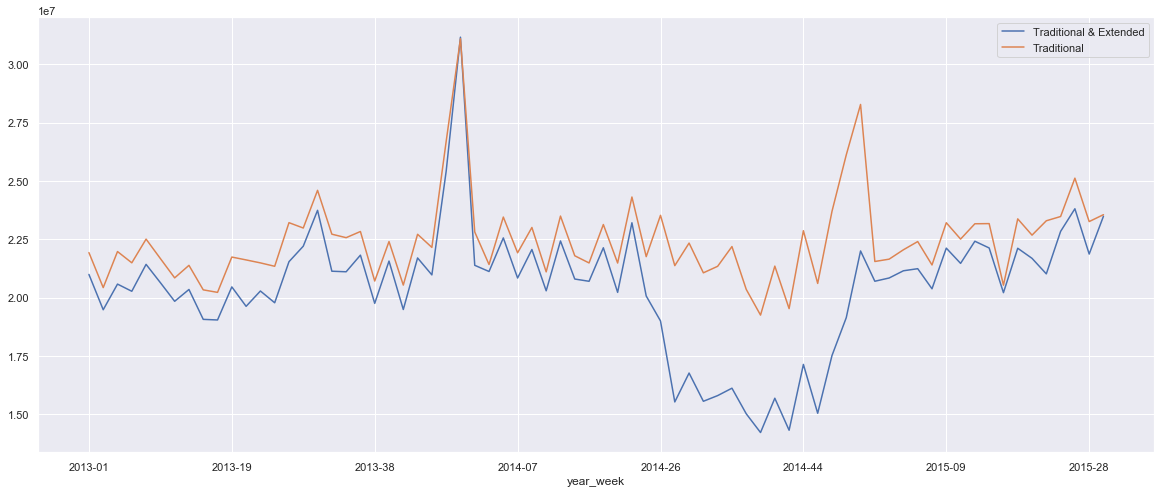

In [68]:
# Check stores sales by year_week (sales in time) with respect to promo and promo2
aux6_1 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux6_1 = aux6_1.set_index('year_week')
ax = aux6_1.plot( figsize=(20,8))

# Only stores with promo
aux6_2 = df4[ (df4['promo'] == 1) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()

aux6_2.plot( ax=ax)

ax.legend( labels=['Traditional & Extended', 'Traditional'])

In [69]:
aux6_1.head()

,sales
year_week,
2013-01,20995409
2013-03,19481514
2013-05,20580811
2013-07,20273185
2013-09,21426145


### **H7.** Stores open on Christmas time should sell more.
**False** Stores open on Christmas sell less.

Comentários:
Esta análise não representa um insight pois a informação de que as vendas no período do natal são menores já são normalmente de conhecimento do time de negócios.

Será uma variável relevante para o modelo, pois as vendas nos feriados cresceram de 2013 para 2014 e diminuiram de 2014 para 2015. Relevância média.

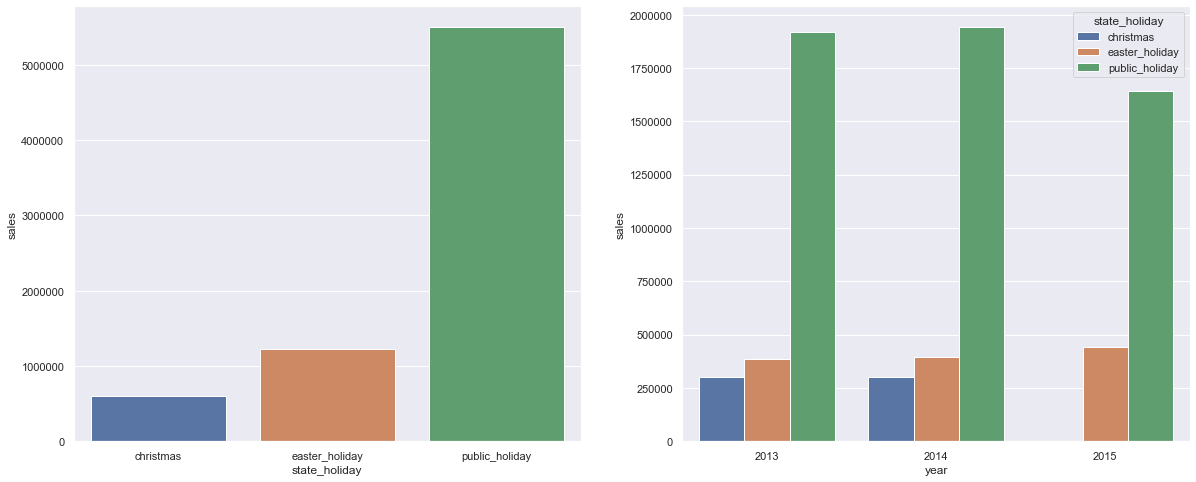

In [70]:
# filter state_holiday without 'regular_day'
aux = df4[df4['state_holiday'] != 'regular_day']

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 2, 1)
# sum of sales by state_holiday
aux7_1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux7_1);


# set up subplot
plt.subplot( 1, 2, 2)
# sum of sales by state_holiday and year
aux7_2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux7_2)

### **H8.** Stores should sell more throughout the years.
**FALSE** Stores sell less throughout the years.

Comentários:
Esta análise não representa um insight pois os analistas de negócios acompanham a métrica de vendas por ano. A análise mostra uma queda nas vendas de 2013 a 2015, o que pode ser um sinal de alerta para o negócio. Obs: o ano de 2015 ainda não está fechado no dataset, ou seja, é um valor que tende a crescer até o final daquele ano.

Correlação de pearson alto, relevante para o modelo. Relevância alta.

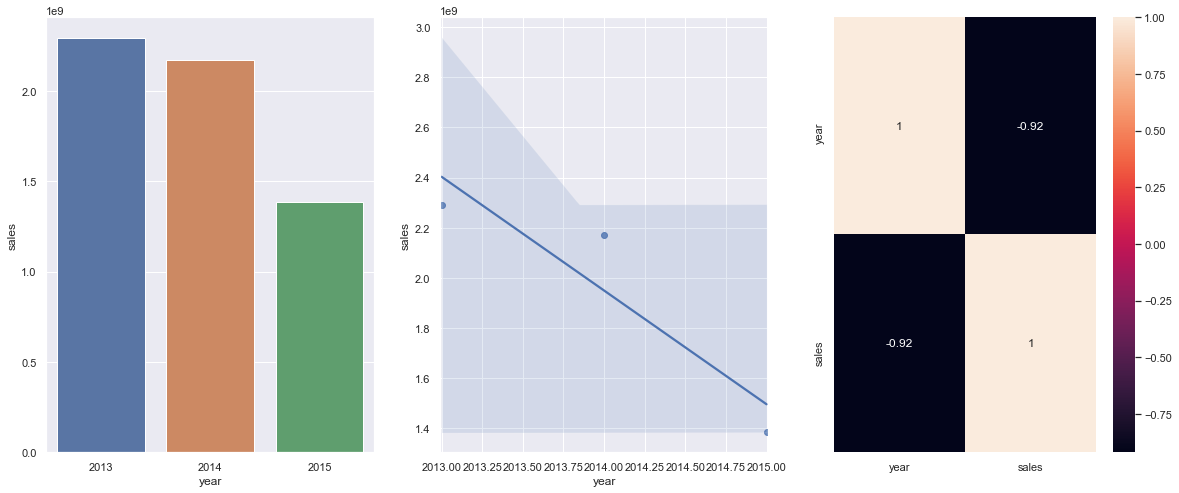

In [71]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by year
aux8_1 = df4[['year', 'sales']].groupby( 'year').sum().reset_index()
sns.barplot( x='year', y='sales', data=aux8_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='year', y='sales', data=aux8_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux8_1.corr( method='pearson'), annot=True);

### **H9.** Stores should sell more on second semester.
**FALSE** Stores sell less on second semester.

Comentários:
Esta análise não gera um insight pois depende muito do negócio.

Correlação de pearson relevante: -0,75 (enquanto o número do mês sobe, as vendas descem). Relevância alta.

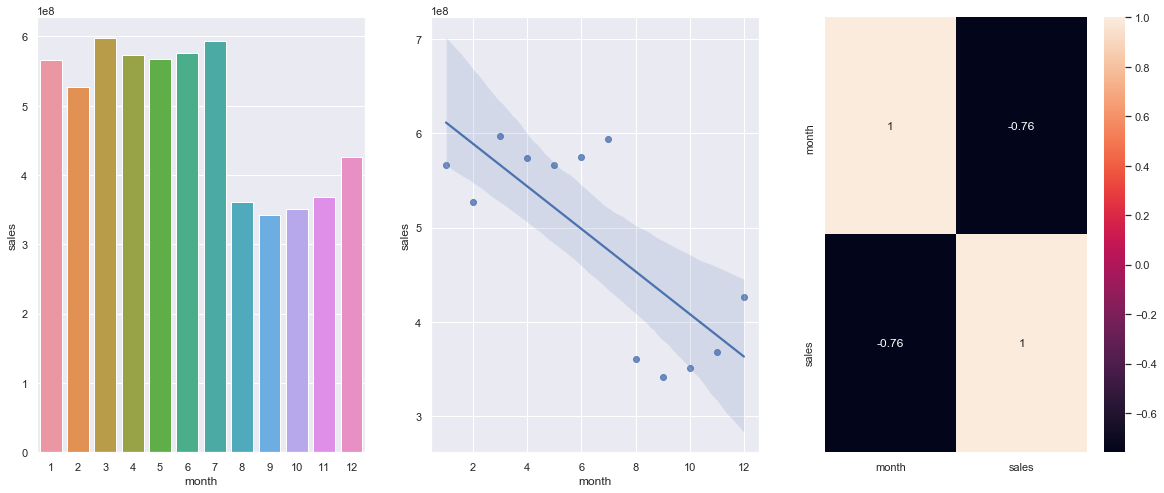

In [72]:
# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by month
aux9_1 = df4[['month', 'sales']].groupby( 'month').sum().reset_index()
sns.barplot( x='month', y='sales', data=aux9_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='month', y='sales', data=aux9_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux9_1.corr( method='pearson'), annot=True);

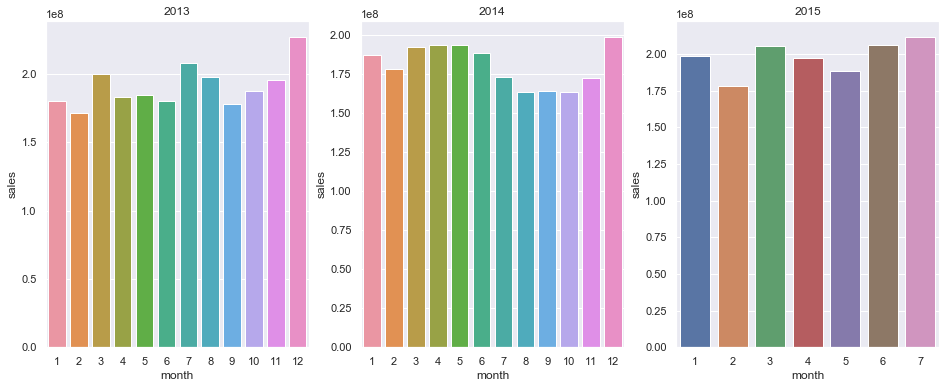

In [73]:
# month, year
# year 2013
aux9_1 = df4[df4['year'] == 2013][['month', 'sales']].groupby('month').sum().reset_index()
# plots
plt.subplots(1, 3, figsize=(16,6))
# 2013 - 1st plot
plt.subplot(1, 3, 1)
plt.title('2013')
sns.barplot(x='month', y='sales', data=aux9_1);

# year 2014
aux9_2 = df4[df4['year'] == 2014][['month', 'sales']].groupby('month').sum().reset_index()
# 2014 - 2nd plot
plt.subplot(1, 3, 2)
plt.title('2014')
sns.barplot(x='month', y='sales', data=aux9_2);

# year 2015
aux9_3 = df4[df4['year'] == 2015][['month', 'sales']].groupby('month').sum().reset_index()
# 2015 - 3rd plot
plt.subplot(1, 3, 3)
plt.title('2015')
sns.barplot(x='month', y='sales', data=aux9_3);

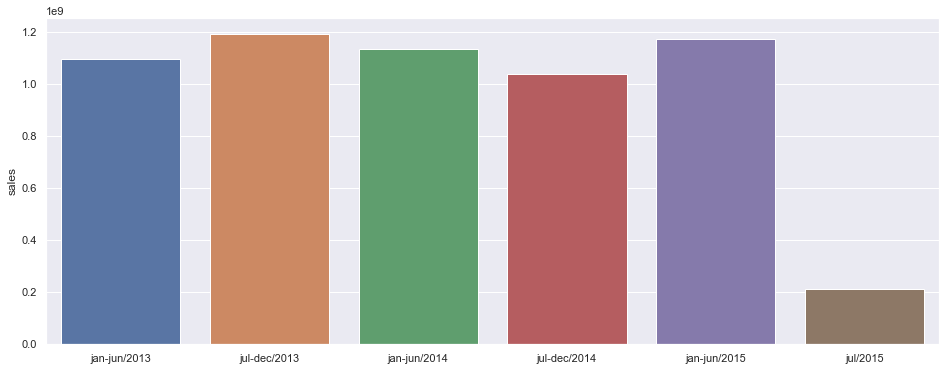

In [74]:
# sum of sales between january and june 2013
aux9_1_1 = aux9_1[(aux9_1['month'] >= 1) & (aux9_1['month'] <= 6)]['sales'].sum()
# sum of sales between january and june 2014
aux9_1_2 = aux9_2[(aux9_2['month'] >= 1) & (aux9_2['month'] <= 6)]['sales'].sum()
# sum of sales between january and june 2015
aux9_1_3 = aux9_3[(aux9_3['month'] >= 1) & (aux9_2['month'] <= 6)]['sales'].sum()

# sum of sales between july and december 2013
aux9_1_4 = aux9_1[(aux9_1['month'] >= 7) & (aux9_1['month'] <= 12)]['sales'].sum()
# sum of sales between july and december 2014
aux9_1_5 = aux9_2[(aux9_2['month'] >= 7) & (aux9_2['month'] <= 12)]['sales'].sum()
# sum of sales july 2015
aux9_1_6 = aux9_3[(aux9_3['month'] >= 7)]['sales'].sum()

df9_1 = pd.DataFrame({'sales':[aux9_1_1, aux9_1_4, aux9_1_2, aux9_1_5, aux9_1_3, aux9_1_6]}, 
                     index=['jan-jun/2013', 'jul-dec/2013','jan-jun/2014','jul-dec/2014',
                           'jan-jun/2015', 'jul/2015'])

plt.subplots(figsize=(16,6))
sns.barplot(x=df9_1.index, y='sales', data=df9_1)

### **H10.** Stores should sell more after the 10th day of the month.
**FALSE** Stores sell less after the 10th day of the month.

Comentários:
Esta análise não é uym insight pois os analistas de negócios acompanham este tipo de métrica.

A variável pode ser relevante para o modelo. Relevância alta.

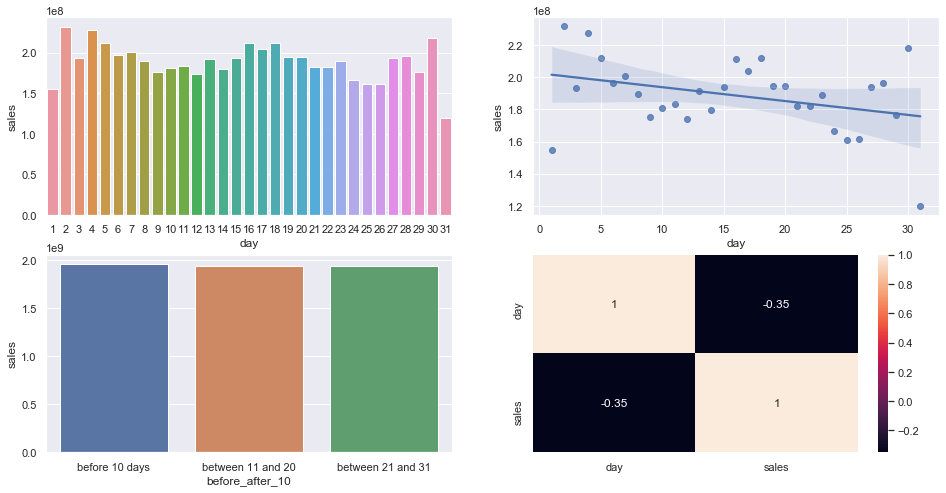

In [76]:
# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# set up subplot
plt.subplot( 2, 2, 1)
# sum of sales by day
aux10 = df4[['day', 'sales']].groupby( 'day').sum().reset_index()
sns.barplot( x='day', y='sales', data=aux10 );

# set up subplot
plt.subplot( 2, 2, 2)
# Trend graph
sns.regplot( x='day', y='sales', data=aux10);

# before and after 10 days
aux10['before_after_10'] = aux10['day'].apply( lambda x: 'before 10 days' if x <= 10 else 'between 11 and 20' if (x > 10 and x <= 20) else 'between 21 and 31')
aux10_1 = aux10.groupby('before_after_10').sum().reset_index()
# barplot - 3rd plot
plt.subplot(2, 2, 3)
sns.barplot(x='before_after_10', y='sales', data=aux10_1);

# heatmap - 4th plot
plt.subplot(2, 2, 4)
aux10_2 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.heatmap(aux10_2.corr(method='pearson'), annot=True);

In [77]:
aux10_1

,before_after_10,day,sales
0,before 10 days,55,1963006487
1,between 11 and 20,155,1939634210
2,between 21 and 31,286,1947118484


### **H11.** Stores should sell less on weekend.
**TRUE** Stores sell less on weekend.

Comentários:
Esta análise não deve gerar um insight pois os analistas de negócios acompanham este tipo de métrica.

Correlação de pearson de -0,76 (forte) relevante para o modelo. Relevância alta.

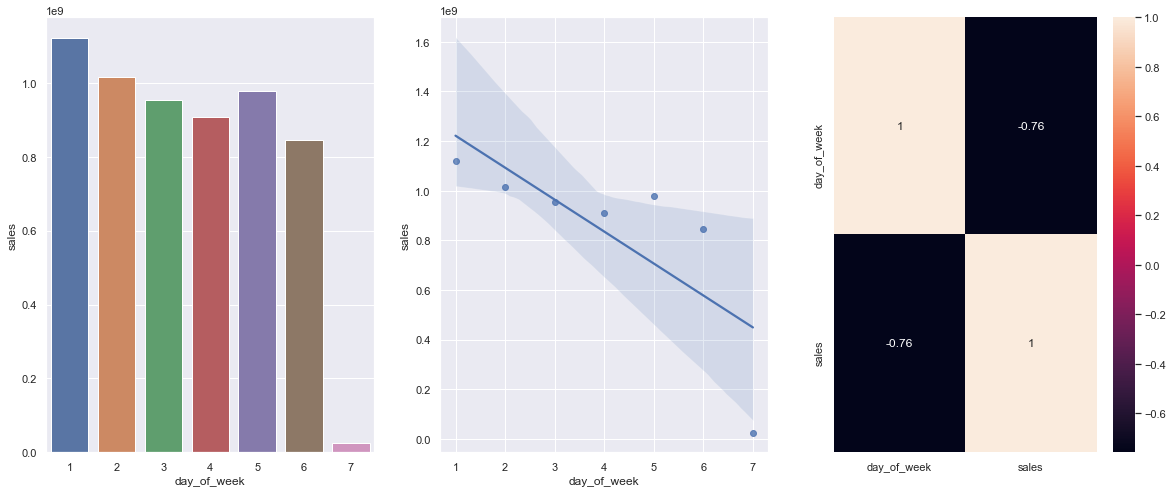

In [78]:
# ISO week day: Monday is 1 and Sunday is 7.

# set up figure size
f, ax = plt.subplots(figsize=(20,8))

# set up subplot
plt.subplot( 1, 3, 1)
# sum of sales by day_of_week
aux11_1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week').sum().reset_index()
sns.barplot( x='day_of_week', y='sales', data=aux11_1 );

# set up subplot
plt.subplot( 1, 3, 2)
# Trend graph
sns.regplot( x='day_of_week', y='sales', data=aux11_1);

# set up subplot
plt.subplot( 1, 3, 3)
# correlation graph (heatmap)
sns.heatmap( aux11_1.corr( method='pearson'), annot=True);

### **H12.** Stores should sell less while school vacation.
**TRUE** Stores sell less during school vacation, except in July and August.

Comentários:
Esta análise não deve gerar um insight pois os analistas de negócios acompanham este tipo de métrica.

Variável relevante para o modelo pois nos meses 7 (aprox.) e 8 as vendas durante as férias escolares são maiores do que nos dias comuns.

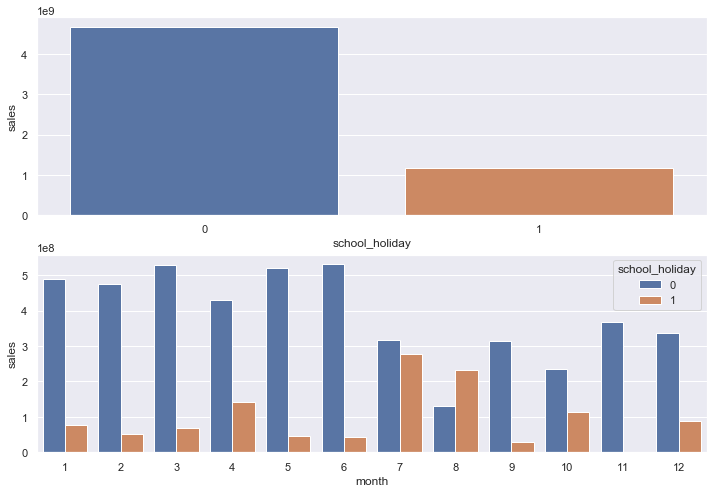

In [79]:
# set up figure size
f, ax = plt.subplots(figsize=(12,8))

# set up subplot
plt.subplot( 2, 1, 1)
# sum of sales by school_holiday
aux12_1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux12_1);

# set up subplot
plt.subplot( 2, 1, 2)
aux12_2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux12_2);

### **H13.** Stores with more customers should sell more.
**TRUE** Stores with more customers sell more.

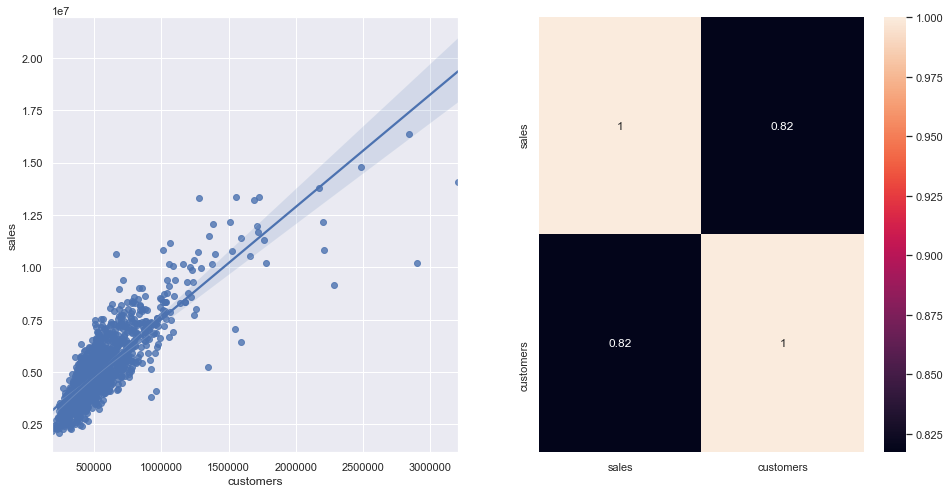

In [94]:
# set up plot
plt.subplots(1, 2, figsize=(16,8) )

# customers and sales regplot
aux13 = df4[['store', 'customers', 'sales']].groupby('store').sum().reset_index()
plt.subplot(1,2,1)
sns.regplot(x='customers', y='sales', data=aux13);

# heatmap
aux14 = df4[['sales', 'customers']]
plt.subplot(1,2,2)
sns.heatmap(aux14.corr(method='pearson'), annot=True);

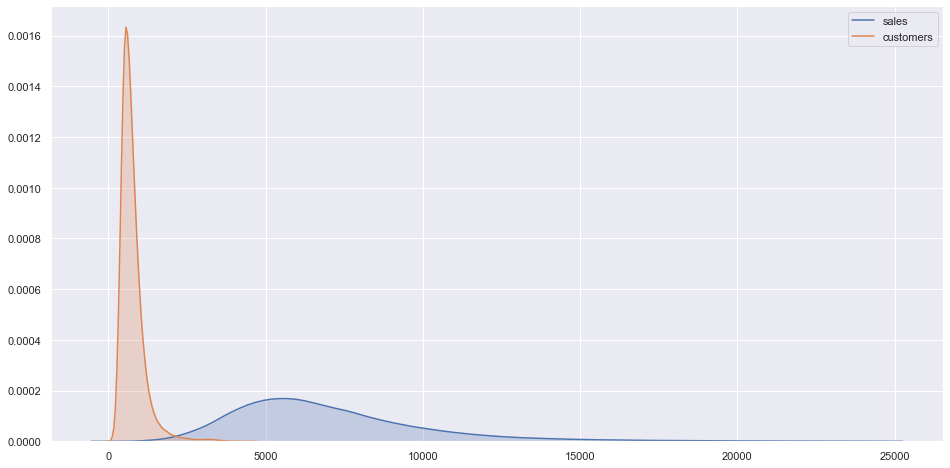

In [87]:
# set up plot
plt.subplots( figsize=(16,8) )

# customers and sales lineplot
sns.kdeplot(df4['sales'], label='sales', shade=True)
sns.kdeplot(df4['customers'], label='customers', shade=True)

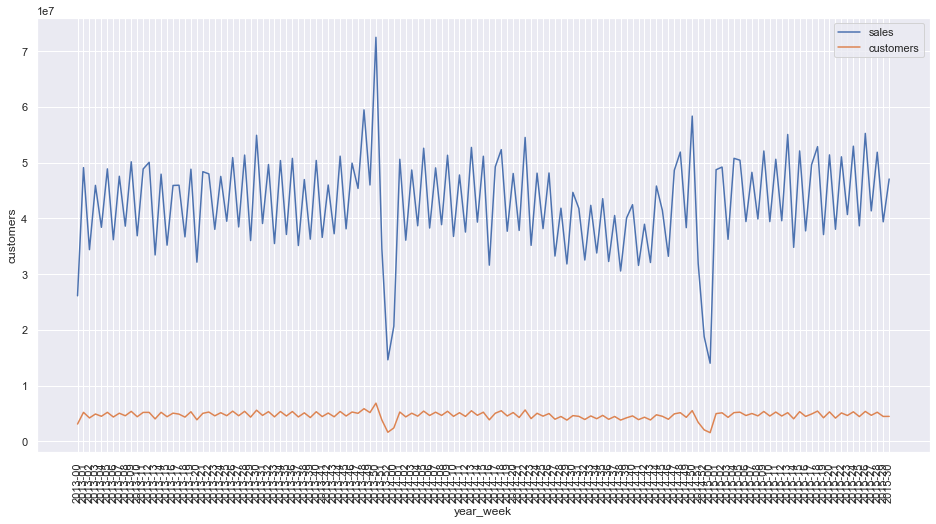

In [92]:
plt.subplots(figsize=(16,8))

# customers, sales, year_week
aux14 = df4[['year_week', 'customers', 'sales']].groupby('year_week').sum().reset_index()
sns.lineplot( x='year_week', y='sales', data=aux14, label='sales' );
sns.lineplot( x='year_week', y='customers', data=aux14, label='customers' );
plt.xticks(rotation=90);

### 4.2.1. Hypothesis Summary

In [98]:
# display columns complete description
pd.set_option('display.max_colwidth', None)

# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Stores with bigger Assortment should sell more.',
                                      'Stores with competition closer should sell less.',
                                      'Stores with longer time competition should sell more.',
                                      'Stores with longer Sale (promo) should sell more.',
                                      'Stores with more Sale (promo) days should sell more.',
                                      'Stores with more consecutive Sale (promo) should sell more.',
                                      'Stores open on Christmas time should sell more.',
                                      'Stores should sell more throughout the years.',
                                      'Stores should sell more on second semester.',
                                      'Stores should sell more after the 10th day of the month.',
                                      'Stores should sell less on weekend.',
                                      'Stores should sell less while school vacation.',
                                      'Stores with more customers should sell more.'],
                        'True / False':['False', 'False', 'False', 'False', 'True', 'False', 'False', 'False', 'False',
                                        'False', 'False', 'True', 'True'], 
                        'Relevance':['Low', 'Medium', 'Medium', 'Low', 'Medium', 'Low', 'Medium', 'High', 'High', 'High',
                                     'High', 'Low', 'High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
summary

,Hypothesis,True / False,Relevance
1,Stores with bigger Assortment should sell more.,False,Low
2,Stores with competition closer should sell less.,False,Medium
3,Stores with longer time competition should sell more.,False,Medium
4,Stores with longer Sale (promo) should sell more.,False,Low
5,Stores with more Sale (promo) days should sell more.,True,Medium
6,Stores with more consecutive Sale (promo) should sell more.,False,Low
7,Stores open on Christmas time should sell more.,False,Medium
8,Stores should sell more throughout the years.,False,High
9,Stores should sell more on second semester.,False,High
10,Stores should sell more after the 10th day of the month.,False,High


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

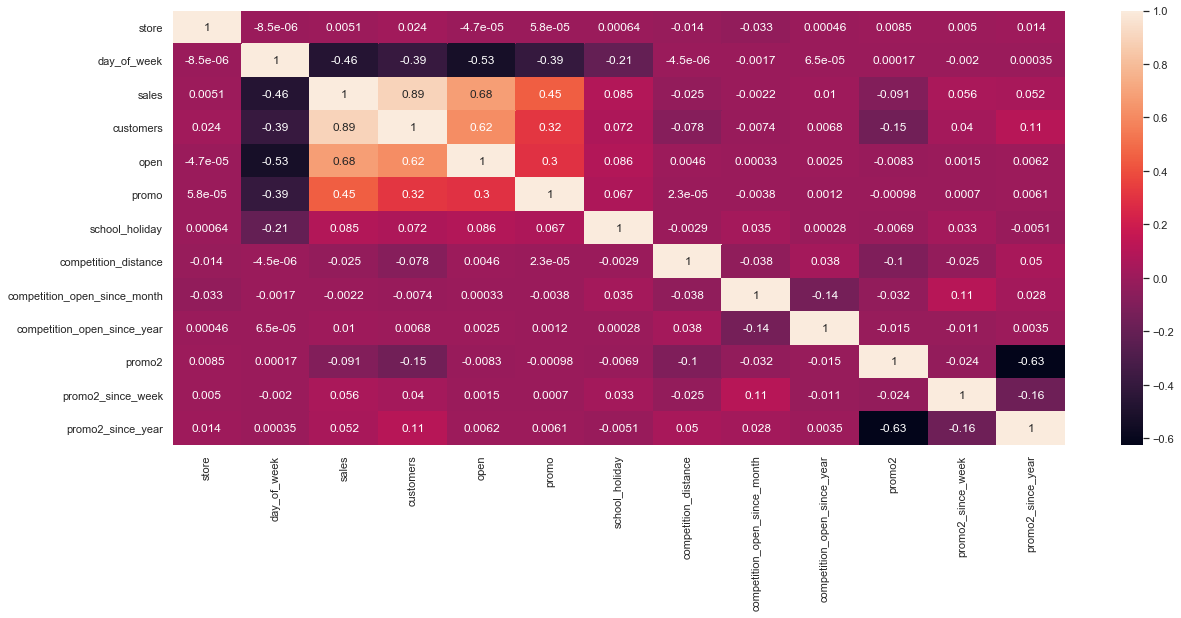

In [99]:
# select numerical columns from the df1
numeric_cols = [cname for cname in df1.columns if df1[cname].dtype in ['int64', 'float64']]
num_attributes = df1[numeric_cols]

# correlation by pearosn method
correlation = num_attributes.corr( method='pearson' )

# set up figure size
f, ax = plt.subplots( figsize=(20,8))

sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [100]:
# Select categorical attributes
a = df4.select_dtypes( include='object' )
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [101]:
# confusion matrix makes all the possible combinations between categorical variables
# and count the number of lines of that combination.
a[(a['state_holiday'] == 'christmas' ) & ( a['store_type'] == 'a' )]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


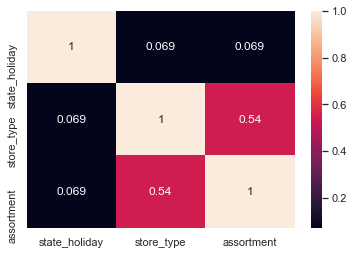

In [102]:
# calculate Cramer V
# Cramer V (chi2) formula is in the 0.1. Helper Functions subsection.
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9] })

d = d.set_index( d.columns)

sns.heatmap( d, annot=True)

# 5.0. STEP 05 - DATA PREPARATION

In [21]:
# Copy the previous dataframe. Remove auxiliary column 'compare'.
df5 = df4.copy()

In [129]:
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic


## 5.1. Standardization

Remark: None of the numerical variables have a normal distribution (see subsection 4.1.2.), therefore the Standardization will not be applied.

## 5.2. Rescaling

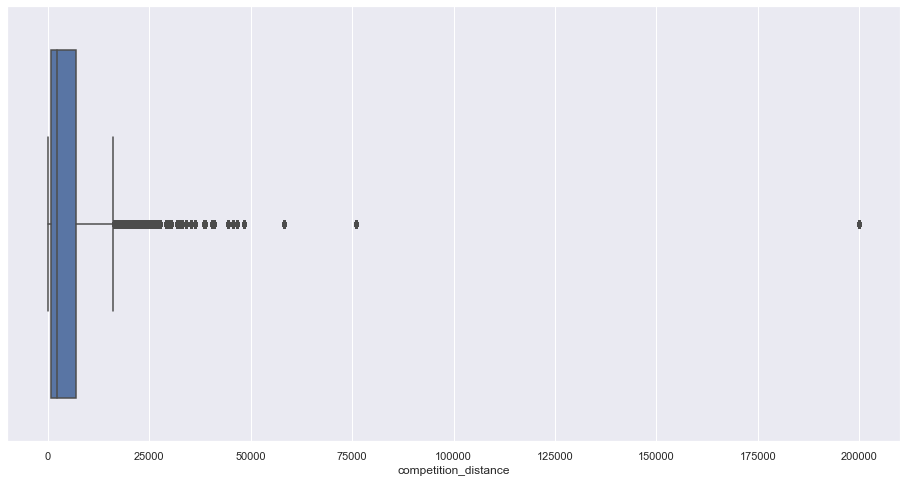

In [104]:
# Check competition_distance outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# boxplot of competition_distance to check outliers
sns.boxplot( df5['competition_distance'] )

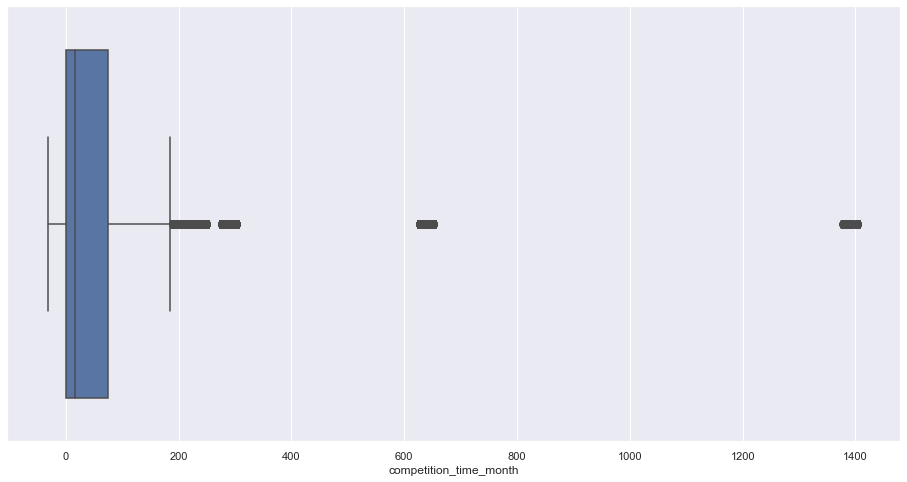

In [76]:
# Check competition_time_month outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# boxplot of competition_time_month to check outliers
sns.boxplot( df5['competition_time_month'] )

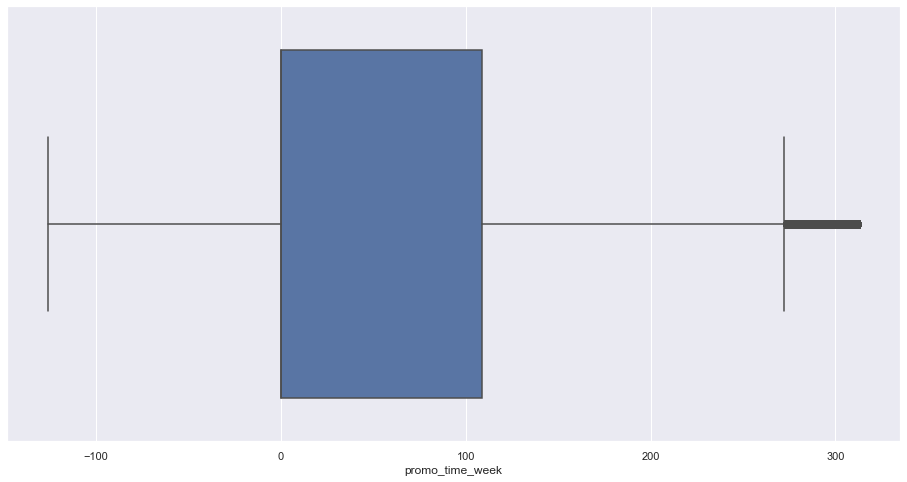

In [77]:
# Check promo_time_week outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# boxplot of promo_time_week to check outliers
sns.boxplot( df5['promo_time_week'] )

In [130]:
# competition_distance, competition_time_month, competition_open_since_year
df5[['competition_distance', 'competition_time_month', 'competition_open_since_year', 'customers']].describe()

,competition_distance,competition_time_month,competition_open_since_year,customers
count,843493.000000,843493.000000,843493.000000,843493.000000
mean,5966.188149,41.684249,2010.330646,760.133896
std,12596.971783,66.832258,5.504085,391.458882
min,20.000000,-32.000000,1900.000000,8.000000
25%,710.000000,0.000000,2008.000000,519.000000
50%,2330.000000,16.000000,2012.000000,675.000000
75%,6910.000000,74.000000,2014.000000,892.000000
max,200000.000000,1407.000000,2015.000000,4645.000000


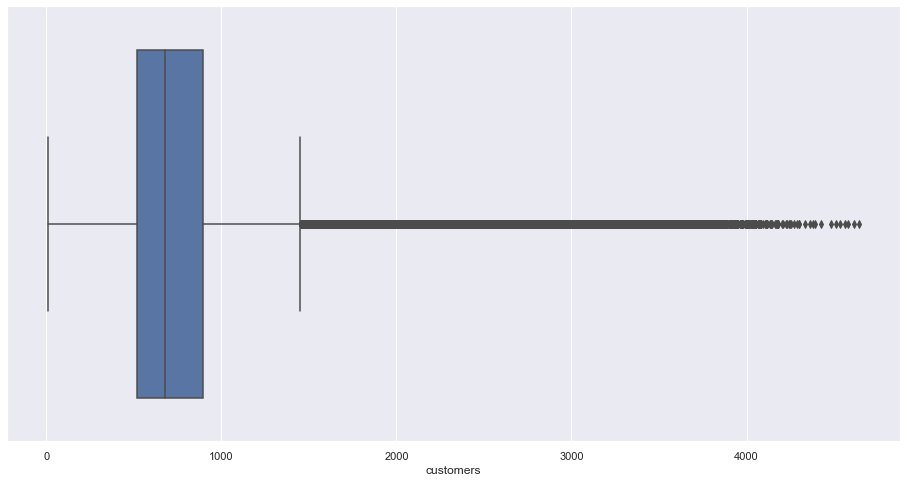

In [131]:
# Check customers outliers

# set up figure size
f, ax = plt.subplots(figsize=(16,8))

# boxplot of customers to check outliers
sns.boxplot( df5['customers'] )

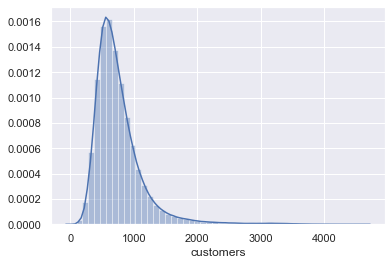

In [132]:
sns.distplot(df5['customers'])

In [106]:
# year variables
df5[['year', 'competition_open_since_year', 'promo2_since_year']].describe()

,year,competition_open_since_year,promo2_since_year
count,843493.000000,843493.000000,843493.000000
mean,2013.832048,2010.330646,2012.797363
std,0.777286,5.504085,1.660375
min,2013.000000,1900.000000,2009.000000
25%,2013.000000,2008.000000,2012.000000
50%,2014.000000,2012.000000,2013.000000
75%,2014.000000,2014.000000,2014.000000
max,2015.000000,2015.000000,2015.000000


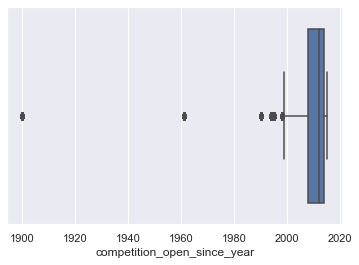

In [107]:
# competition open since year boxplot
sns.boxplot(df5['competition_open_since_year'])

In [22]:
# numerical variables: competition_distance, competition_time_month, promo_time_week, year
# competition_open_since_year, promo2_since_year, customers

# 1. Robust Scaler - for variables with high outliers influence:
# competition_distance, competition_time_month, competition_open_since_year and customers
rs = RobustScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# save competition_distance scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_distance_scaler.pkl', 'wb' ) as f:
     pickle.dump(rs, f)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# save competition_time_month scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_time_month_scaler.pkl', 'wb' ) as f:
     pickle.dump(rs, f)

# competition_open_since_year
df5['competition_open_since_year'] = rs.fit_transform( df5[['competition_open_since_year']].values )  
# save competition_open_since_year scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_open_since_year_scaler.pkl', 'wb' ) as f:
     pickle.dump(rs, f)

# customers
df5['customers'] = rs.fit_transform( df5[['customers']].values )  
# save customers scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/customers_scaler.pkl', 'wb' ) as f:
     pickle.dump(rs, f)


# 2. Min-Max Scaler - for variables with low outliers influence:
# competition_time_month, promo_time_week, year, promo2_since_year
mms = MinMaxScaler()

# competition_time_month
df5['competition_time_month'] = mms.fit_transform( df5[['competition_time_month']].values )
# save competition_time_month scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_time_month.pkl', 'wb' ) as f:
     pickle.dump(mms, f)

# promo_time_week
# The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# save promo_time_week scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo_time_week_scaler.pkl', 'wb' ) as f:
     pickle.dump(mms, f)

# year - apply MinMaxScaler
df5['year'] = mms.fit_transform( df5[['year']].values )
# save year scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/year_scaler.pkl', 'wb' ) as f:
     pickle.dump(mms, f)

# promo2_since_year
df5['promo2_since_year'] = mms.fit_transform( df5[['promo2_since_year']].values )
# save promo2_since_year scaler, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo2_since_year_scaler.pkl', 'wb' ) as f:
     pickle.dump(mms, f)

## 5.3. Transformation

### 5.3.1. Encoding

In [23]:
# state_holiday - apply one-hot encoding with get_dummies from pandas
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - apply label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
# save store_type encoding, so it can be applied in new data (deployment phase)
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/store_type_scaler.pkl', 'wb' ) as f:
     pickle.dump(le, f)

# assortment - apply ordinal encoding
# dictionary does not need to be pickled because dictionary can be created in deploy.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Nature Transformation

In [24]:
# time variables - day_of_week, day, month, week_of_year, competition_open_since_month, promo2_since_week.

# Tranformation application: Cyclic Nature Transformation with sin and cos
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

### 5.3.3. Response Variable (Target) Transformation

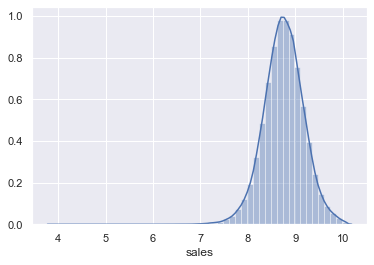

In [25]:
# Transform sales into log in order to obtain a normal distribution
df5['sales'] = np.log1p( df5['sales'] )
sns.distplot(df5['sales'])

In [137]:
df5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,8.56865,8.71029,9.02582,9.54653,8.48115
customers,-0.321716,-0.134048,0.391421,2.20643,-0.310992
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.90323,-0.275806,4.44839


# 6.0. STEP 06 - FEATURE SELECTION

In [26]:
df6 = df5.copy()

## 6.1. Split Dataframe into Training and Test Dataset

In [27]:
# Remove columns that already have a derivative one

# Remove day_of_week due to day_of_week_sin, day_of_week_cos
# Remove competition_open_since_month due to competition_open_since_month_sin, competition_open_since_month_cos
# Remove promo2_since_week due to promo2_since_week_sin, promo2_since_week_cos
# Remove month due to month_sin, month_cos
# Remove day due to day_sin, day_cos
# Remove week_of_year due to week_of_year_sin, week_of_year_cos
# Remove year_week due to week_of_year_sin, week_of_year_cos
# Remove competition_since due to competition_open_since_year, competition_time_month, competition_open_since_month_sin, competition_open_since_month_cos
# Remove promo_since due to promo_time_week, promo2_since_week_sin, promo2_since_week_cos
cols_drop = ['day_of_week', 'competition_open_since_month', 'promo2_since_week', 'month', 'day', 'week_of_year', 
             'year_week', 'competition_since', 'promo_since']

df6 = df6.drop( cols_drop, axis=1 )

In [28]:
# Select the last 6 weeks for the Test Dataset
# Check the day that represents the beginning of the last 6 weeks
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [28]:
# training dataset: entries before the last 6 weeks
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset: entries from the last 6 weeks
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

# print min and max date values
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [142]:
# Boruta disabled in module 07 in order to not run again, since it takes at least 2h 30min.

# Boruta does not accept pandas df format, therefore the dataset must be converted to numpy values
# training and test dataset for Boruta
#x_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# ravel() puts the values into a vector
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# defined Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	20
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [143]:
# Boruta disabled in module 07 in order to not run again, since it takes at least 2h 30min.

#cols_selected = boruta.support_.tolist()

# best features by boruta
#x_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# features not selected by boruta
#cols_not_selected_boruta = list( np.setdiff1d ( x_train_fs.columns, cols_selected_boruta ))

#cols_selected_boruta

['store',
 'customers',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_cos',
 'month_cos',
 'week_of_year_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos']

In [144]:
cols_not_selected_boruta

['day_sin',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [29]:
# Columns selected by boruta. We will save the columns names so that we do not have to run the boruta again
# when we open the notebook
# List the columns selected by boruta
# Added day_sin, month_sin and week_of_year_sin (becuase day_cos, month_cos and week_of_year_cos were chosen by boruta)
cols_selected_boruta = [
 'store',
 'customers',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos']

# Columns to add: date and sales
feat_to_add = ['date', 'sales']

# Select boruta columns with date and sales. It will be applied on cross-validation step.
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [30]:
# Insert columns selected by Boruta on x_train and x_test
# date and sales not included! They will be included later.
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [32]:
# aux1 variable for calculation
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# sales mean values by stores - prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales' : 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1( yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1347.408189,0.448963,1806.724412


## 7.2. Linear Regression Model

In [34]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )


# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1326.615643,0.182247,3240.058452


The Linear Regression RMSE value is higher than the average model one, that is:
- The average model is better than the linear regression model;
- The data has a complex behaviour (non-linear).

### 7.2.1. Linear Regression Model - Cross Validation

In [37]:
# cross validation function
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1421.6 +/- 208.57,0.19 +/- 0.01,3225.47 +/- 396.45


## 7.3. Linear Regression Regularized Model - Lasso

In [35]:
# Lasso model
# alpha parameter: fator multiplicativo de cada um dos pesos para que eles fiquem dentro de um range.
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )


# performance
lrr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1381.074406,0.187097,3030.020298


Linear Regression regularized model (Lasso) RMSE value was higher than standard linear regression.
Conclusion: the phenomenon that we measure it is not linear. It is also no simple, therefore a complex model. 

### 7.3.1. Lasso - Cross Validation

In [38]:
# cross validation function
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1463.68 +/- 229.62,0.19 +/- 0.01,3039.18 +/- 398.24


## 7.4. Random Forest Regressor

In [39]:
# Random Forest Regressor disabled in Step 10 due to long-time execution (aprox. 15 minutes)

# Random Forest Regressor model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )


# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,375.598941,0.053044,550.861198


### 7.4.1. Random Forest Regressor - Cross Validation

In [40]:
# Cross Validation disabled in module 08 in order to not run again, since it takes at least 30min.
# cross validation function
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,403.27 +/- 97.55,0.05 +/- 0.01,581.91 +/- 144.2


## 7.5. XGBoost Regressor

In [33]:
# model
# eta: quantas 'passadas' o modelo usa para fazer o aprendizado
# max_depth: máxima profundidade que a árvore pode chegar
# subsample: quantas amostras / porcentagem de todas as variáveis para selecionar as mais relevantes
# colsample_bytee: xgboost é composto por várias árvores; sample por cada uma das árvores
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,387.155093,0.055727,548.74325


### 7.5.1. XGBoost Regressor - Cross Validation

In [41]:
# Cross Validation disabled in module 08 in order to not run again, since it takes at least 16min.
# cross validation function
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,423.49 +/- 48.08,0.06 +/- 0.0,590.45 +/- 73.88


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [42]:
# concatenate models results
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,387.155093,0.055727,548.743250
0,Random Forest Regressor,375.598941,0.053044,550.861198
0,Average Model,1347.408189,0.448963,1806.724412
0,Linear Regression,1381.074406,0.187097,3030.020298
0,Linear Regression,1326.615643,0.182247,3240.058452


### 7.6.2. Real Performance - Cross Validation

In [43]:
# concatenate models results
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1421.6 +/- 208.57,0.19 +/- 0.01,3225.47 +/- 396.45
0,Lasso,1463.68 +/- 229.62,0.19 +/- 0.01,3039.18 +/- 398.24
0,Random Forest Regressor,403.27 +/- 97.55,0.05 +/- 0.01,581.91 +/- 144.2
0,XGBoost Regressor,423.49 +/- 48.08,0.06 +/- 0.0,590.45 +/- 73.88


# 8.0. STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [54]:
# Random Search disabled in order to not run again, since it takes a considerable time to get done.
# Dict with values for the random search
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytee': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }

#MAX_EVAL = 5

In [51]:
# Random Search disabled in order to not run again, since it takes a considerable time to get done.
# Data Frame for final results
#final_result = pd.DataFrame()

# select the values for the random search
#for i in range( MAX_EVAL ):
    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() } # return values from param dictionary
#    print( hp )
    
    # model
#   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytee'],
#                                  min_child_weight=hp['min_child_weight'] )

    # performance
    # k-fold has the same value as MAX_EVAL
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )

#final_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,858.423602,0.125049,1269.734892


## 8.2. Final Model

In [31]:
# XGBRegressor disabled in Step 10 due to long-time execution (aprox. 1 hour)

# Dict with values from the random search result.
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 3
        }

In [32]:
# XGBRegressor disabled in Step 10 due to long-time execution (aprox. 1 hour)

# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,315.458723,0.046363,450.909289


In [33]:
# Mean percentage error
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.0017269428545662452

In [34]:
# save the trained, tuned XGBoost model
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/model/model_xgb_rossmann_v02.pkl', 'wb' ) as f:
    pickle.dump(model_xgb_tuned, f)

In [31]:
# load the trained, tuned XGBoost model
with open( 'C:/Users/santo/repos/DataScience-Em-Producao/model/model_xgb_rossmann_v02.pkl', 'rb' ) as f:
     model_xgb_tuned = pickle.load(f)

In [32]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,315.458723,0.046363,450.909289


## 8.3. XGBoost Regressor (tuned) - Cross-Validation

In [36]:
# XGBoost tuned cross-validation
xgb_tuned_cv = cross_validation( x_training, 5, 'XGBoost Regressor (tuned)', model_xgb_tuned, verbose=True )
xgb_tuned_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor (tuned),349.0 +/- 28.1,0.05 +/- 0.0,488.21 +/- 50.16


# 9.0. STEP 09 - ERROR TRANSLATION AND INTERPRETATION

In [33]:
# select full test data (with date and sales)
df9 = X_test[ cols_selected_boruta_full ]

# rescale sales and model prediction
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [37]:
# sum of predictions, sum of sales
df91 = df9[['sales','store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [38]:
# sort stores with higher MAPE
df92.sort_values( 'MAPE', ascending=False ).head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,288480.0,256475.140625,254228.916341,258721.364909,2246.224284,0.164578
303,304,248644.0,286735.187500,285698.333747,287772.041253,1036.853753,0.159877
875,876,230226.0,198090.156250,196145.992121,200034.320379,1944.164129,0.148535
136,137,290994.0,324957.062500,324039.141826,325874.983174,917.920674,0.127061
291,292,108805.0,89614.914062,88344.435621,90885.392504,1270.478441,0.122659


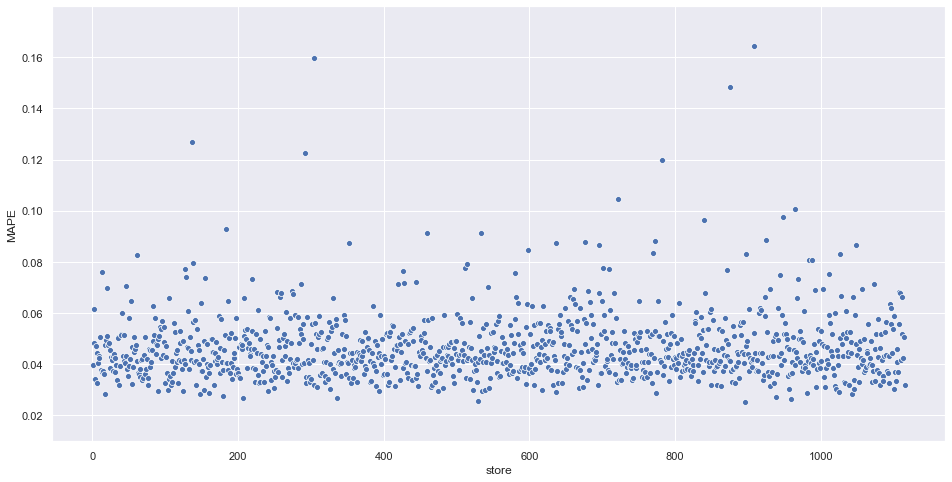

In [36]:
# scatter plot
# set up figure size
f, ax = plt.subplots( figsize=(16,8))
sns.scatterplot( x='store', y='MAPE', data=df92)

In [39]:
df92.sample(4)

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
135,136,208200.0,210224.187500,209980.790501,210467.584499,243.396999,0.045198
686,687,334224.0,321542.875000,321042.211307,322043.538693,500.663693,0.055845
818,819,218179.0,212028.890625,211769.208325,212288.572925,259.682300,0.045393
320,321,226732.0,224848.171875,224589.152740,225107.191010,259.019135,0.040665


## 9.2. Total Performance

In [40]:
# sum of values from all stores
df93 = df92[['sales','predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenarios', 0:'total_sales'})
df93['total_sales'] = df93['total_sales'].map( 'R$ {:,.2f}'.format)
df93

,Scenarios,total_sales
0,sales,"R$ 288,533,817.00"
1,predictions,"R$ 287,616,333.89"
2,worst_scenario,"R$ 287,262,820.88"
3,best_scenario,"R$ 287,969,846.90"


## 9.3. Machine Learning Performance

In [41]:
# error
df9['error'] = df9['sales'] - df9['predictions']

#error rate
df9['error_rate'] = df9['predictions'] / df9['sales']

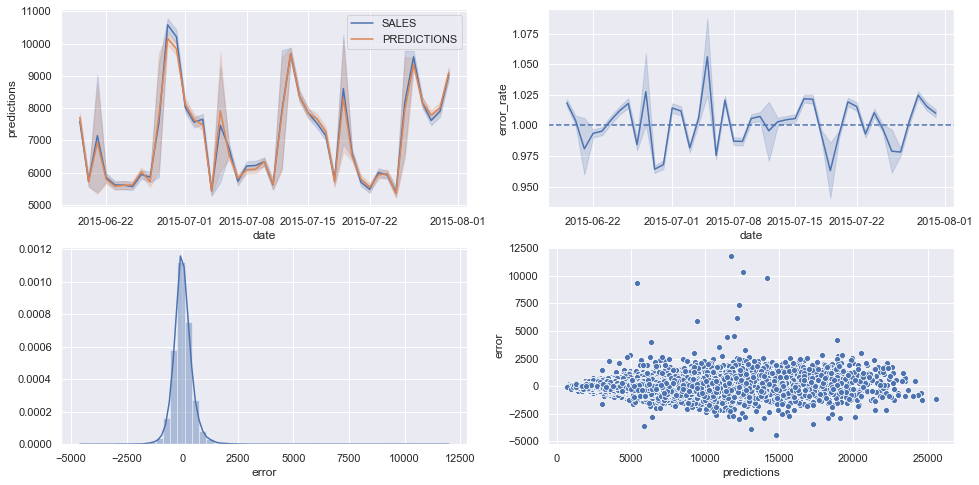

In [42]:
# set up figure size
f, ax = plt.subplots( figsize=(16,8))

# lineplot date x sales x predictions
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# lineplot date x error_rate
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
# add line in the lineplot
plt.axhline( 1, linestyle='--')

# plot error distribution
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

# scatter plot predictions x error
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

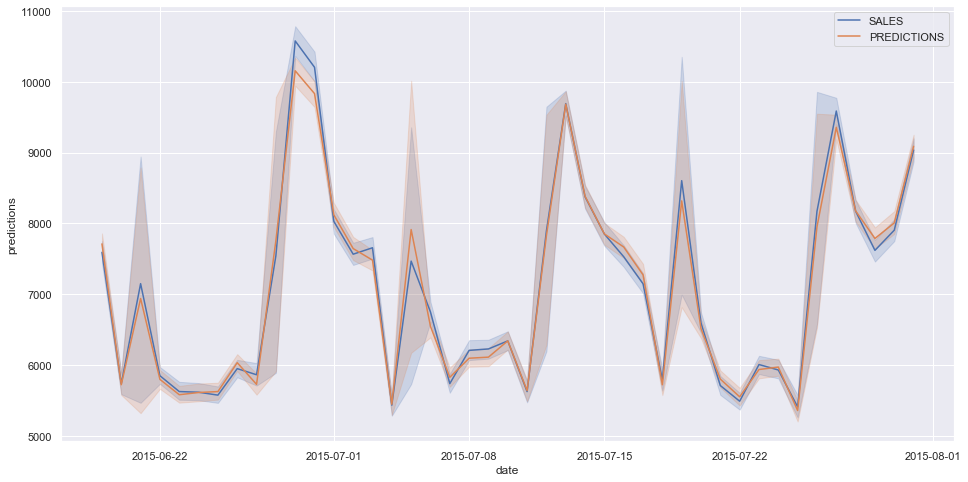

In [48]:
# sales x predictions
# set up figure size
plt.subplots( figsize=(16,8))

# lineplot date x sales x predictions
sns.lineplot( x='date', y='sales', data=df9, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' );

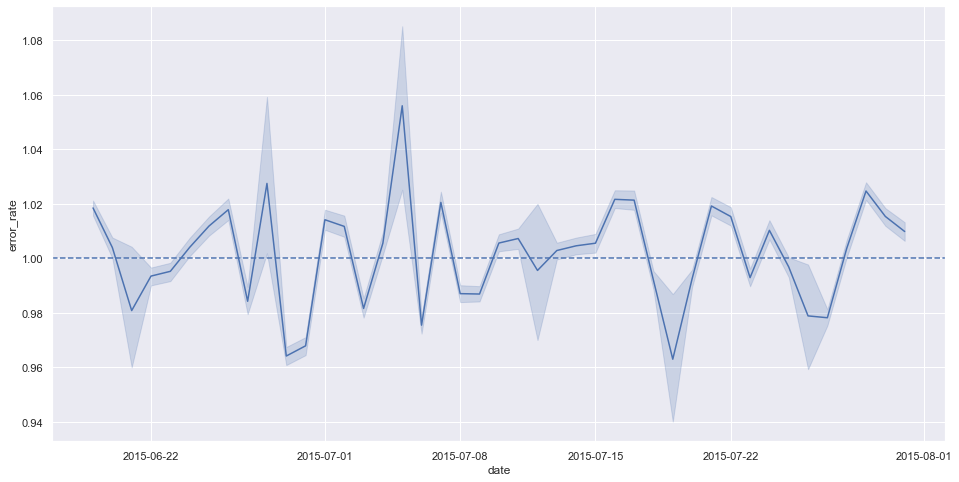

In [49]:
# error rate
plt.subplots(figsize=(16,8))
# lineplot date x error_rate
sns.lineplot( x='date', y='error_rate', data=df9 )
# add line in the lineplot
plt.axhline( 1, linestyle='--')

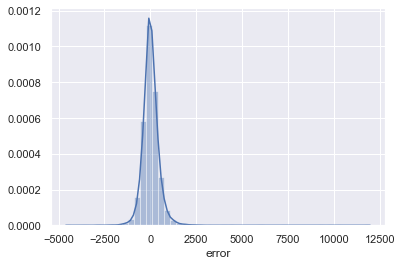

In [50]:
# error distribution
sns.distplot( df9['error'] );

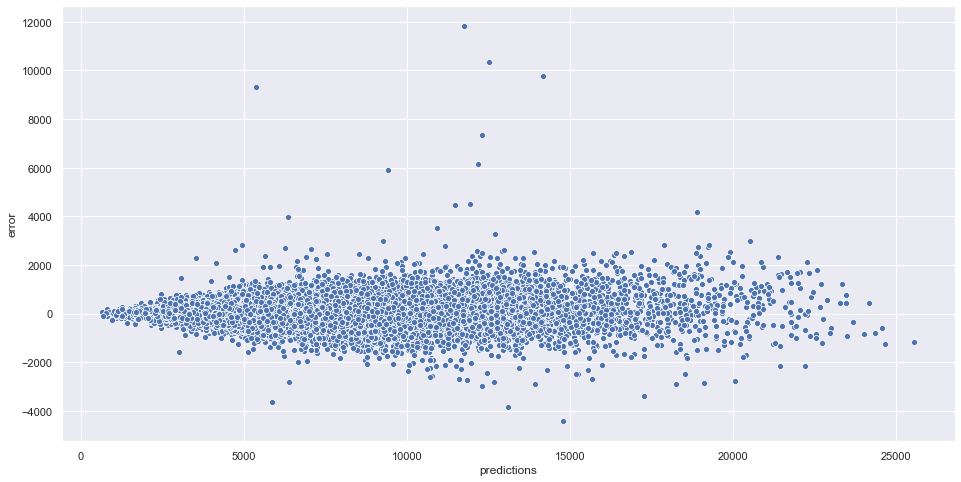

In [51]:
# error x predictions
plt.subplots(figsize=(16,8))
sns.scatterplot( df9['predictions'], df9['error'] );

## 9.4. Best and Worst MAPE

In [43]:
# sort stores with higher MAPE
df92.sort_values( 'MAPE', ascending=False ).head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,288480.0,256475.140625,254228.916341,258721.364909,2246.224284,0.164578
303,304,248644.0,286735.187500,285698.333747,287772.041253,1036.853753,0.159877
875,876,230226.0,198090.156250,196145.992121,200034.320379,1944.164129,0.148535
136,137,290994.0,324957.062500,324039.141826,325874.983174,917.920674,0.127061
291,292,108805.0,89614.914062,88344.435621,90885.392504,1270.478441,0.122659


In [44]:
# sort stores with lower MAPE
df92.sort_values( 'MAPE', ascending=True ).head()

,store,sales,predictions,worst_scenario,best_scenario,MAE,MAPE
895,896,266362.0,265073.15625,264891.046505,265255.265995,182.109745,0.025144
528,529,305728.0,302594.56250,302370.769426,302818.355574,223.793074,0.025494
958,959,264766.0,264083.06250,263892.363618,264273.761382,190.698882,0.026466
335,336,501861.0,497914.75000,497542.702148,498286.797852,372.047852,0.026704
206,207,416348.0,414226.34375,413897.050715,414555.636785,329.293035,0.026918


In [45]:
# sum of all sales by store and by date
aux2 = df9[['date', 'store', 'sales', 'predictions']].groupby( ['date', 'store'] ).sum().reset_index()
aux2

,date,store,sales,predictions
0,2015-06-19,1,4202.0,4524.953125
1,2015-06-19,2,4926.0,4819.255371
2,2015-06-19,3,8074.0,7919.707520
3,2015-06-19,4,9686.0,9996.712891
4,2015-06-19,5,5711.0,5532.527832
...,...,...,...,...
41354,2015-07-31,1110,6198.0,6054.083496
41355,2015-07-31,1111,5723.0,5501.505859
41356,2015-07-31,1112,9626.0,10052.914062
41357,2015-07-31,1113,7289.0,7731.444336


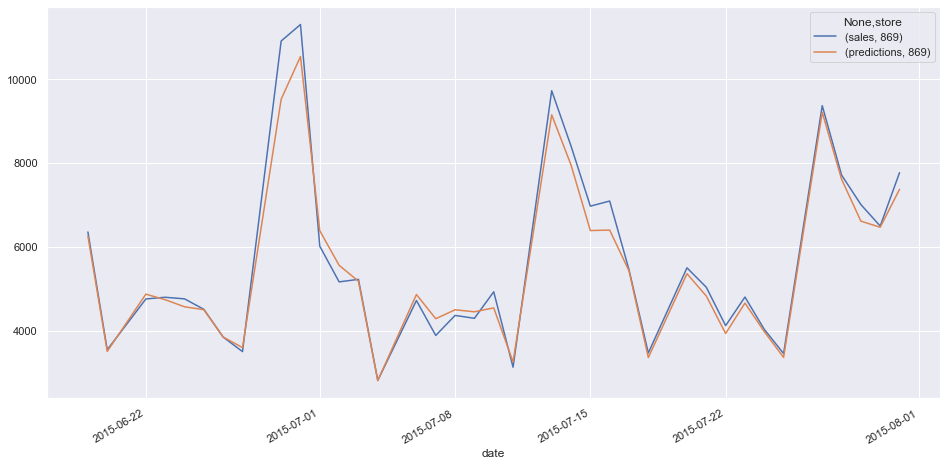

In [46]:
# lineplot store 869 - best prediction
aux4 = aux2[aux2['store'] == 869]
aux4.pivot( index='date', columns='store', values=['sales', 'predictions']).plot(figsize=(16,8))

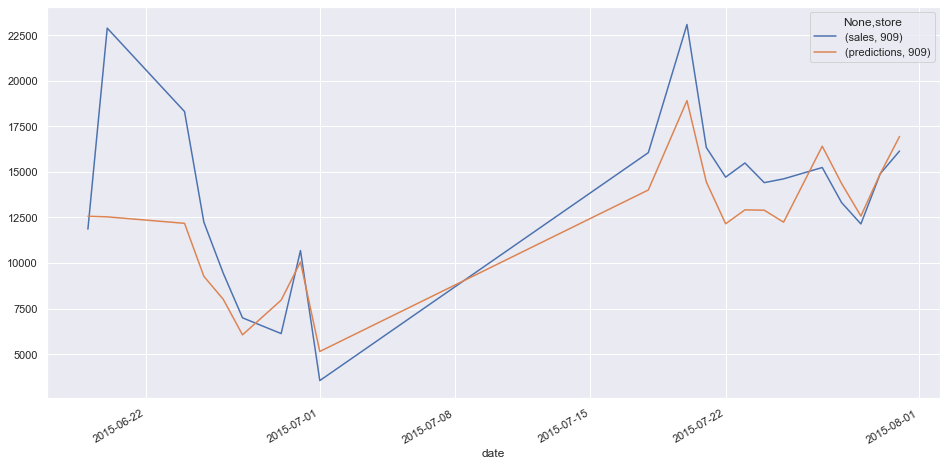

In [47]:
# lineplot store 909 - worst prediction
aux5 = aux2[aux2['store'] == 909]
aux5.pivot( index='date', columns='store', values=['sales', 'predictions']).plot(figsize=(16,8))

# 10.0. STEP 10 - DEPLOY MODEL TO PRODUCTION

## 10.1. Rossmann Class

In [27]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
from datetime import datetime
from datetime import timedelta

class Rossmann_v02( object ):
    def __init__( self ):
        self.competition_distance_scaler        = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler      = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_time_month_scaler.pkl', 'rb' ) )
        self.competition_open_since_year_scaler = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_open_since_year_scaler.pkl', 'rb' ) )
        self.customers_scaler                   = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/customers_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler             = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                        = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/year_scaler.pkl', 'rb' ) )
        self.promo2_since_year_scaler           = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo2_since_year_scaler.pkl', 'rb' ) )
        self.store_type_scaler                  = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/store_type_scaler.pkl', 'rb' ) )
    
    def data_cleaning( self, df1 ):
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
                   'SchoolHoliday', 'Customers', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        # Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance
        # market analysis assumption: position without values means a far competition distance, higher than the
        # maximum value from the raw data.
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        # Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
        # over time the sales performance.
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        # Same assumption as competition_open_since_month
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        # Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        # Same assumption as promo2_since_week
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
        # Fill NA values with zero.
        df1['promo_interval'].fillna(0, inplace=True)

        ## 1.6. Change Types

        # change competition_open_since_month type to int
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

        # change competition_open_since_year type to int
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        # change promo2_since_week type to int
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

        # change promo2_since_year type to int
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        # change customers type to int
        df1['customers'] = df1['customers'].astype('int64')
        
        return df1

    
    def feature_engineering( self, df2 ):
        
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        # Bring together competition_open_since_month and competition_open_since_year
        # Assumption: day = 1 in order to consider the full month.
        df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

        # Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        # 1. Create a string 'year-week'
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        # 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
        # 3. create promo_time_week column with the difference between date and promo_since in weeks.
        # df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. STEP 03 - VARIABLES FILTERING

        ## 3.1. Line Filtering
        # closed stores (open = 0) means no sales. Therefore, it is not relevant for the sales forecast model. Open = 0 will be removed.
        # sales = 0 will also be removed.
        df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection

        # Customers is a variable that is not available at the time of prediction, hence it is a business restriction.
        # To use Customers variable, a new project is needed only for customers forecast in the next 6 weeks, and then use it as input in this sales forecast project.
        # Therefore, the column customers must be removed.
        # open only has values = 1(the lines with zeros were deleted above), hence the column can be removed.
        # promo_interval generated new columns in the feature engineering step and is no longer needed.
        # month_map is an auxiliary column and hence will be removed.
        cols_drop = ['open', 'promo_interval']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition_time_month
        # Apply RobustScaler due to the presence of outliers.
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
       
        # competition_open_since_year
        df5['competition_open_since_year'] = self.competition_open_since_year_scaler.fit_transform( df5[['competition_open_since_year']].values ) 
    
        # customers
        df5['customers'] = self.customers_scaler.fit_transform( df5[['customers']].values )
    
        # promo_time_week
        # The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year - apply MinMaxScaler
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        # promo2_since_year
        df5['promo2_since_year'] = self.promo2_since_year_scaler.fit_transform( df5[['promo2_since_year']].values )


        ### 5.3.1. Encoding

        # state_holiday - apply one-hot encoding with get_dummies from pandas
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - apply label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - apply ordinal encoding
        # dictionary does not need to be pickled because dictionary can be created in deploy.
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation

        # Tranformation application: Cyclic Nature Transformation with sin and cos
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
        
        # competition_open_since_month
        df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
        df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

        # promo2_since_week
        df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
        df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )
        
        
        
        cols_selected = ['store','customers', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_year', 'promo2', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos',
                         'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos',
                         'competition_open_since_month_sin', 'competition_open_since_month_cos',
                         'promo2_since_week_sin', 'promo2_since_week_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [30]:
# import pickle
import pickle
# import pandas
import pandas as pd
# import flask
from flask import Flask, request, Response
#import Rossmann class
from rossmann.Rossmann_v02 import Rossmann_v02

# load model
model = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/model/model_xgb_rossmann_v02.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

# create endpoint (URL)
# Post method = send data in order to receive data.
@app.route( '/rossmann/predict', methods=['POST'] )
# function to get the received data
def rossmann_predict():
    test_json = request.get_json()
    
    #check received data (json)
    if test_json: # there is data
        if isinstance( test_json, dict): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() ) # keys = chaves do json. Serão as colunas do df.
        
        # Instantiate Rossmann class
        pipeline = Rossmann_v02()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else: # there is no data
        return Response( '{}', status=200, mimetype='application/json' )

# check main function in the script
if __name__ == '__main__':
    app.run( '127.0.0.1' ) # local host

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [39]:
import requests

In [52]:
# load test dataset
df10 = pd.read_csv('C:/Users/santo/repos/DataScience-Em-Producao/data/test_customers.csv')

In [53]:
df10.dtypes

Id                 int64
Store              int64
DayOfWeek          int64
Date              object
Open             float64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
Customers        float64
dtype: object

In [90]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [75] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [91]:
df_test.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Open                         float64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
Customers                    float64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [92]:
df_test.columns

Index(['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Customers', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [93]:
df_test.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
57,75,4,2015-09-17,1.0,1,0,0,758.111726,d,c,22440.0,12.0,2013.0,0,NaN,NaN,NaN
909,75,3,2015-09-16,1.0,1,0,0,711.390008,d,c,22440.0,12.0,2013.0,0,NaN,NaN,NaN
1761,75,2,2015-09-15,1.0,1,0,0,683.429415,d,c,22440.0,12.0,2013.0,0,NaN,NaN,NaN
2613,75,1,2015-09-14,1.0,1,0,0,752.457231,d,c,22440.0,12.0,2013.0,0,NaN,NaN,NaN
3492,75,6,2015-09-12,1.0,0,0,0,617.083187,d,c,22440.0,12.0,2013.0,0,NaN,NaN,NaN


In [94]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [95]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict' # url local
url = 'https://rossmann-model-v02.herokuapp.com/rossmann/predict' # endpoint heroku rossmann-model-v02
header = {'Content-type': 'application/json'}
data = data

# requests = send requsition to endpoint with data.
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format(r.status_code ) )

Status Code 200


In [96]:
# convert back to data frame
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [97]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,customers,store_type,assortment,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,75,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,758,d,extended,...,2015,9,17,38,2015-37,2013-12-01T00:00:00.000Z,21,2015-09-14T00:00:00.000Z,0,11156.488281
1,75,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,711,d,extended,...,2015,9,16,38,2015-37,2013-12-01T00:00:00.000Z,21,2015-09-14T00:00:00.000Z,0,9894.173828
2,75,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,683,d,extended,...,2015,9,15,38,2015-37,2013-12-01T00:00:00.000Z,21,2015-09-14T00:00:00.000Z,0,8674.492188
3,75,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,0,752,d,extended,...,2015,9,14,38,2015-37,2013-12-01T00:00:00.000Z,21,2015-09-14T00:00:00.000Z,0,12312.744141
4,75,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,617,d,extended,...,2015,9,12,37,2015-36,2013-12-01T00:00:00.000Z,21,2015-09-07T00:00:00.000Z,0,4402.192871


In [98]:
# sum prediction
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

# test for other stores
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format( d2.loc[i, 'store'], d2.loc[i, 'prediction'] ) )

Store Number 75 will sell R$ 231,484.75 in the next 6 weeks.


In [99]:
data

'[{"Store": 75, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "Customers": 758.1117261136422, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 22440.0, "CompetitionOpenSinceMonth": 12.0, "CompetitionOpenSinceYear": 2013.0, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "PromoInterval": NaN}, {"Store": 75, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "Customers": 711.3900081887657, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 22440.0, "CompetitionOpenSinceMonth": 12.0, "CompetitionOpenSinceYear": 2013.0, "Promo2": 0, "Promo2SinceWeek": NaN, "Promo2SinceYear": NaN, "PromoInterval": NaN}, {"Store": 75, "DayOfWeek": 2, "Date": "2015-09-15", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "Customers": 683.4294152833282, "StoreType": "d", "Assortment": "c", "CompetitionDistance": 22440.0, "CompetitionOpenSinceMonth": 12

## 10.4. Rossmann_v02.py Tester

In [13]:
df1 = df_test.copy()

### 10.4.1. Data Cleaning df1

In [14]:
## 1.1. Rename Columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
           'SchoolHoliday', 'Customers', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Apply snakecase to columns names - letras minusculas. Nomes compostos separados por "_".
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.3. Data Types
df1['date'] = pd.to_datetime( df1['date'] )

## 1.5. Fillout NA
#competition_distance
# market analysis assumption: position without values means a far competition distance, higher than the
# maximum value from the raw data.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# Assumption: for NA values apply the value from "date" column, because the competition does exist and it can affect
# over time the sales performance.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
# Same assumption as competition_open_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
# Assumptions: 1. NA values mean the store did not take place in promo2. 2. apply the value from "date" column.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
# Same assumption as promo2_since_week
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
        
# Fill NA values with zero.
df1['promo_interval'].fillna(0, inplace=True)

## 1.6. Change Types

# change competition_open_since_month type to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

# change competition_open_since_year type to int
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

# change promo2_since_week type to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

# change promo2_since_year type to int
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
# change customers type to int
df1['customers'] = df1['customers'].astype('int64')


In [15]:
df1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,customers,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
13,20,4,2015-09-17,1.0,1,0,0,1066,d,a,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct"
15,22,4,2015-09-17,1.0,1,0,0,912,a,a,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct"
16,23,4,2015-09-17,1.0,1,0,0,560,d,a,4060.0,8,2005,0,38,2015,0
865,20,3,2015-09-16,1.0,1,0,0,978,d,a,2340.0,5,2009,1,40,2014,"Jan,Apr,Jul,Oct"
867,22,3,2015-09-16,1.0,1,0,0,898,a,a,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct"


In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
open                                   float64
promo                                    int64
state_holiday                           object
school_holiday                           int64
customers                                int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
dtype: object

### 10.4.2. Feature Engineering df2

In [17]:
df2 = df1.copy()

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
# Bring together competition_open_since_month and competition_open_since_year
# Assumption: day = 1 in order to consider the full month.
df2['competition_since'] = df2.apply( lambda x: datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)

# Calculate the difference between date and competition_since. divide by 30 to keep the monthly granularity.
df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
# 1. Create a string 'year-week'
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
# 2. transform the string to date format ('year-month-day'). The day represents the first day of the week.
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7) )
# 3. create promo_time_week column with the difference between date and promo_since in weeks.
# df2['date'] - df2['promo_since'] divided by 7 beacuse we want it in weeks.
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. STEP 03 - VARIABLES FILTERING

## 3.1. Line Filtering
df2 = df2[df2['open'] != 0]

        ## 3.2. Columns Selection
cols_drop = ['open', 'promo_interval']
df2 = df2.drop( cols_drop, axis=1 )

In [20]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
promo                                    int64
state_holiday                           object
school_holiday                           int64
customers                                int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

In [21]:
df2.head()

,store,day_of_week,date,promo,state_holiday,school_holiday,customers,store_type,assortment,competition_distance,...,promo2_since_year,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
13,20,4,2015-09-17,1,regular_day,0,1066,d,basic,2340.0,...,2014,2015,9,17,38,2015-37,2009-05-01,77,2014-09-29,50
15,22,4,2015-09-17,1,regular_day,0,912,a,basic,1040.0,...,2012,2015,9,17,38,2015-37,2015-09-01,0,2012-05-21,173
16,23,4,2015-09-17,1,regular_day,0,560,d,basic,4060.0,...,2015,2015,9,17,38,2015-37,2005-08-01,123,2015-09-14,0
865,20,3,2015-09-16,1,regular_day,0,978,d,basic,2340.0,...,2014,2015,9,16,38,2015-37,2009-05-01,77,2014-09-29,50
867,22,3,2015-09-16,1,regular_day,0,898,a,basic,1040.0,...,2012,2015,9,16,38,2015-37,2015-09-01,0,2012-05-21,173


### 10.4.3. Data Preparation df5

In [29]:
df5 = df2.copy()

In [30]:
competition_distance_scaler        = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_distance_scaler.pkl', 'rb' ) )
competition_time_month_scaler      = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_time_month_scaler.pkl', 'rb' ) )
competition_open_since_year_scaler = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/competition_open_since_year_scaler.pkl', 'rb' ) )
customers_scaler                   = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/customers_scaler.pkl', 'rb' ) )
promo_time_week_scaler             = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo_time_week_scaler.pkl', 'rb' ) )
year_scaler                        = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/year_scaler.pkl', 'rb' ) )
promo2_since_year_scaler           = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/promo2_since_year_scaler.pkl', 'rb' ) )
store_type_scaler                  = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/parameter02/store_type_scaler.pkl', 'rb' ) )

In [31]:
## 5.2. Rescaling
# competition distance
df5['competition_distance'] = competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

# competition_time_month
# Apply RobustScaler due to the presence of outliers.
df5['competition_time_month'] = competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
       
 # competition_open_since_year
df5['competition_open_since_year'] = competition_open_since_year_scaler.fit_transform( df5[['competition_open_since_year']].values ) 
    
# customers
df5['customers'] = customers_scaler.fit_transform( df5[['customers']].values )
    
# promo_time_week
# The boxplot graph shows a low outlier influence, hence the MinMaxScaler will be applied.
df5['promo_time_week'] = promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
# year - apply MinMaxScaler
df5['year'] = year_scaler.fit_transform( df5[['year']].values )
        
# promo2_since_year
df5['promo2_since_year'] = promo2_since_year_scaler.fit_transform( df5[['promo2_since_year']].values )

### 5.3.1. Encoding

# state_holiday - apply one-hot encoding with get_dummies from pandas
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - apply label encoding
df5['store_type'] = store_type_scaler.fit_transform( df5['store_type'] )

# assortment - apply ordinal encoding
# dictionary does not need to be pickled because dictionary can be created in deploy.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.3. Nature Transformation

# Tranformation application: Cyclic Nature Transformation with sin and cos
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7 ) ) )
        
# competition_open_since_month
df5['competition_open_since_month_sin'] = df5['competition_open_since_month'].apply( lambda x: np.sin( x * (2. * np.pi/12 ) ) )
df5['competition_open_since_month_cos'] = df5['competition_open_since_month'].apply( lambda x: np.cos( x * (2. * np.pi/12 ) ) )

# promo2_since_week
df5['promo2_since_week_sin'] = df5['promo2_since_week'].apply( lambda x: np.sin( x * (2. * np.pi/52 ) ) )
df5['promo2_since_week_cos'] = df5['promo2_since_week'].apply( lambda x: np.cos( x * (2. * np.pi/52 ) ) )
        
cols_selected = ['store','customers', 'promo', 'store_type', 'assortment', 'competition_distance',
                         'competition_open_since_year', 'promo2', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos',
                         'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos',
                         'competition_open_since_month_sin', 'competition_open_since_month_cos',
                         'promo2_since_week_sin', 'promo2_since_week_cos']

df5 = df5[cols_selected]

In [32]:
df5.dtypes

store                                 int64
customers                           float64
promo                                 int64
store_type                            int32
assortment                            int64
competition_distance                float64
competition_open_since_year         float64
promo2                                int64
promo2_since_year                   float64
competition_time_month              float64
promo_time_week                     float64
day_of_week_sin                     float64
day_of_week_cos                     float64
day_sin                             float64
day_cos                             float64
month_sin                           float64
month_cos                           float64
week_of_year_sin                    float64
week_of_year_cos                    float64
competition_open_since_month_sin    float64
competition_open_since_month_cos    float64
promo2_since_week_sin               float64
promo2_since_week_cos           

In [33]:
df5.head()

,store,customers,promo,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,competition_time_month,...,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos
13,20,1.163934,1,1,1,0.000000,0.0,1,0.666667,0.008197,...,-0.406737,-0.913545,-1.0,-1.836970e-16,-0.992709,-0.120537,0.500000,-8.660254e-01,-0.992709,0.120537
15,22,0.743169,1,0,1,-0.430464,0.6,1,0.000000,-0.622951,...,-0.406737,-0.913545,-1.0,-1.836970e-16,-0.992709,-0.120537,-1.000000,-1.836970e-16,0.464723,-0.885456
16,23,-0.218579,1,1,1,0.569536,-0.4,0,1.000000,0.385246,...,-0.406737,-0.913545,-1.0,-1.836970e-16,-0.992709,-0.120537,-0.866025,-5.000000e-01,-0.992709,-0.120537
865,20,0.923497,1,1,1,0.000000,0.0,1,0.666667,0.008197,...,-0.207912,-0.978148,-1.0,-1.836970e-16,-0.992709,-0.120537,0.500000,-8.660254e-01,-0.992709,0.120537
867,22,0.704918,1,0,1,-0.430464,0.6,1,0.000000,-0.622951,...,-0.207912,-0.978148,-1.0,-1.836970e-16,-0.992709,-0.120537,-1.000000,-1.836970e-16,0.464723,-0.885456


### 10.4.4. Prediction

In [34]:
df_test_pred = df_test.copy()

In [35]:
# load model
model = pickle.load( open( 'C:/Users/santo/repos/DataScience-Em-Producao/model/model_xgb_rossmann_v02.pkl', 'rb') )

pred = model.predict( df5 )
        
# join pred into the original data
df_test_pred['prediction'] = np.expm1( pred )

In [36]:
df_test_pred.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
13,20,4,2015-09-17,1.0,1,0,0,1066.948377,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",7981.076660
15,22,4,2015-09-17,1.0,1,0,0,912.837562,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",8447.661133
16,23,4,2015-09-17,1.0,1,0,0,560.856315,d,a,4060.0,8.0,2005.0,0,NaN,NaN,NaN,4652.329590
865,20,3,2015-09-16,1.0,1,0,0,978.454427,d,a,2340.0,5.0,2009.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct",7689.488770
867,22,3,2015-09-16,1.0,1,0,0,898.908105,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct",8316.304688


In [38]:
# sum prediction
d2 = df_test_pred[['Store', 'prediction']].groupby( 'Store' ).sum().reset_index()

# test for other stores
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R$ {:,.2f} in the next 6 weeks.'.format( d2.loc[i, 'Store'], d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$ 238,098.86 in the next 6 weeks.
Store Number 22 will sell R$ 271,203.88 in the next 6 weeks.
Store Number 23 will sell R$ 167,146.62 in the next 6 weeks.
